<a href="https://colab.research.google.com/github/Ufelicita/mscproject/blob/main/Stock_Price_Prediction_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google drive

In [5]:

# Mount google drive in Google Collab
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Install required libraries
Install yfinance using pip to retrieve a wide range of historical stock data from yahoo finance.



In [6]:
# Install yfinance
!pip install yfinance ta keras-tuner


## Import necessary libraries

This is required for EDA, Data preprocessing , Model building , Training and Evaluation


In [7]:
import yfinance as yf
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD, SMAIndicator
from ta.volatility import BollingerBands
import keras_tuner as kt
import matplotlib.dates as mdates
import random
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Attention
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Attention, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Attention, Dropout, BatchNormalization, Concatenate, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from kerastuner.tuners import Hyperband


<ipython-input-7-d541821b98d6>:33: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [8]:
def set_random_seeds(seed=42):
    """
    Set random seeds for reproducibility in Python, NumPy, and TensorFlow.

    Parameters:
    - seed (int): The seed value to use for random number generation. Default is 42.

    Returns:
    - None
    """
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    print(f"Random seeds set to {seed} for reproducibility.")

## Function to download historical stock data

##Loading the data set

This step involves loading the datasets using pandas  
and inspecting the data set structure to understand its
contents and columns .


In [9]:
def download_and_process_data(tickers, start_date, end_date, output_dir):
    """
    The function downloads historical data for the given tickers from
     Yahoo Finance,saves it to CSV files in a specified output directory,
     processes each dataset, and returns a merged dataframe.

    Parameters:
    - tickers: list of stock tickers to download data for
    - start_date: start date for historical data in 'YYYY-MM-DD' format
    - end_date: end date for historical data in 'YYYY-MM-DD' format
    - output_dir: directory to save the CSV files

    Returns:
    - merged_df: DataFrame with merged data for all tickers
    """
    os.makedirs(output_dir, exist_ok=True)
    processed_dfs = []

    for ticker in tickers:
        print(f"Downloading data for {ticker}")
        data = yf.download(ticker, start=start_date, end=end_date)
        file_path = os.path.join(output_dir, f"{ticker}_historical_data.csv")
        data.to_csv(file_path)
        print(f"Data for {ticker} saved to {file_path}")

        # Process the data
        df = pd.read_csv(file_path, header=0)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.drop(labels=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
        df = df.rename(columns={'Adj Close': ticker.split('.')[0]})

        processed_dfs.append(df)

    # Merge all dataframes on 'Date'
    merged_df = processed_dfs[0]
    for df in processed_dfs[1:]:
        merged_df = pd.merge(merged_df, df, on='Date', how='inner')

    return merged_df

# List tickers to download data
tickers = ['BATS.L', 'CCH.L', 'LAND.L', 'SVT.L', 'GLEN.L', 'RR.L', 'RTO.L',
           'SGE.L', 'LGEN.L', 'SN.L']

# Indicate start and end date for historical data
start_date = '2014-01-01'
end_date = '2023-12-31'

# Save CSV to directory
output_dir = 'historical_data'

# Call the function and capture the merged dataframe
merged_df = download_and_process_data(tickers, start_date, end_date, output_dir)

# Display the merged dataframe
print(merged_df)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Data for BATS.L saved to historical_data/BATS.L_historical_data.csv


Data for CCH.L saved to historical_data/CCH.L_historical_data.csv


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Data for LAND.L saved to historical_data/LAND.L_historical_data.csv



[*********************100%%**********************]  1 of 1 completed


Data for SVT.L saved to historical_data/SVT.L_historical_data.csv
Data for GLEN.L saved to historical_data/GLEN.L_historical_data.csv


[*********************100%%**********************]  1 of 1 completed


Data for RR.L saved to historical_data/RR.L_historical_data.csv


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for RTO.L saved to historical_data/RTO.L_historical_data.csv


[*********************100%%**********************]  1 of 1 completed

Data for SGE.L saved to historical_data/SGE.L_historical_data.csv
Data for LGEN.L saved to historical_data/LGEN.L_historical_data.csv



[*********************100%%**********************]  1 of 1 completed

Data for SN.L saved to historical_data/SN.L_historical_data.csv
           Date         BATS          CCH        LAND          SVT  \
0    2014-01-02  1680.686890  1241.764160  645.337524  1098.838623   
1    2014-01-03  1676.757324  1215.688232  652.825684  1109.217285   
2    2014-01-06  1679.639038  1236.125977  654.527466  1105.325562   
3    2014-01-07  1669.159668  1268.544312  664.738464  1081.325073   
4    2014-01-08  1652.915527  1254.449219  666.099976  1061.864746   
...         ...          ...          ...         ...          ...   
2511 2023-12-21  2176.073242  2209.205322  696.267212  2551.663574   
2512 2023-12-22  2181.312256  2211.137207  695.300171  2541.957764   
2513 2023-12-27  2177.502197  2210.171143  699.748535  2532.251953   
2514 2023-12-28  2174.168213  2209.205322  692.785950  2516.722656   
2515 2023-12-29  2186.551270  2226.593018  681.568176  2503.134277   

            GLEN          RR         RTO          SGE        LGEN           SN  
0     208.1740

## Exploratory Data Analysis
This includes handling missing values,
 converting columns to datetime ojects ,
 generate summary statistics for the dataset and
  create visulaisations to understand the data
   distribution and relationships

Random seeds set to 42 for reproducibility.

Missing values:
Date    0
BATS    0
CCH     0
LAND    0
SVT     0
GLEN    0
RR      0
RTO     0
SGE     0
LGEN    0
SN      0
dtype: int64

Duplicate rows:
0

Descriptive Statistics:
                                Date         BATS          CCH         LAND  \
count                           2516  2516.000000  2516.000000  2516.000000   
mean   2018-12-25 03:44:21.367249664  2327.028653  1703.292813   685.408551   
min              2014-01-02 00:00:00  1509.604980   765.286682   395.000946   
25%              2016-06-28 18:00:00  2011.315918  1200.081909   596.980789   
50%              2018-12-19 12:00:00  2199.255737  1829.577393   687.274353   
75%              2021-06-21 06:00:00  2688.152466  2098.369141   766.954666   
max              2023-12-29 00:00:00  3410.238281  2504.722168   966.341553   
std                              NaN   414.124651   482.643207   117.805172   

               SVT         GLEN           RR          RTO   

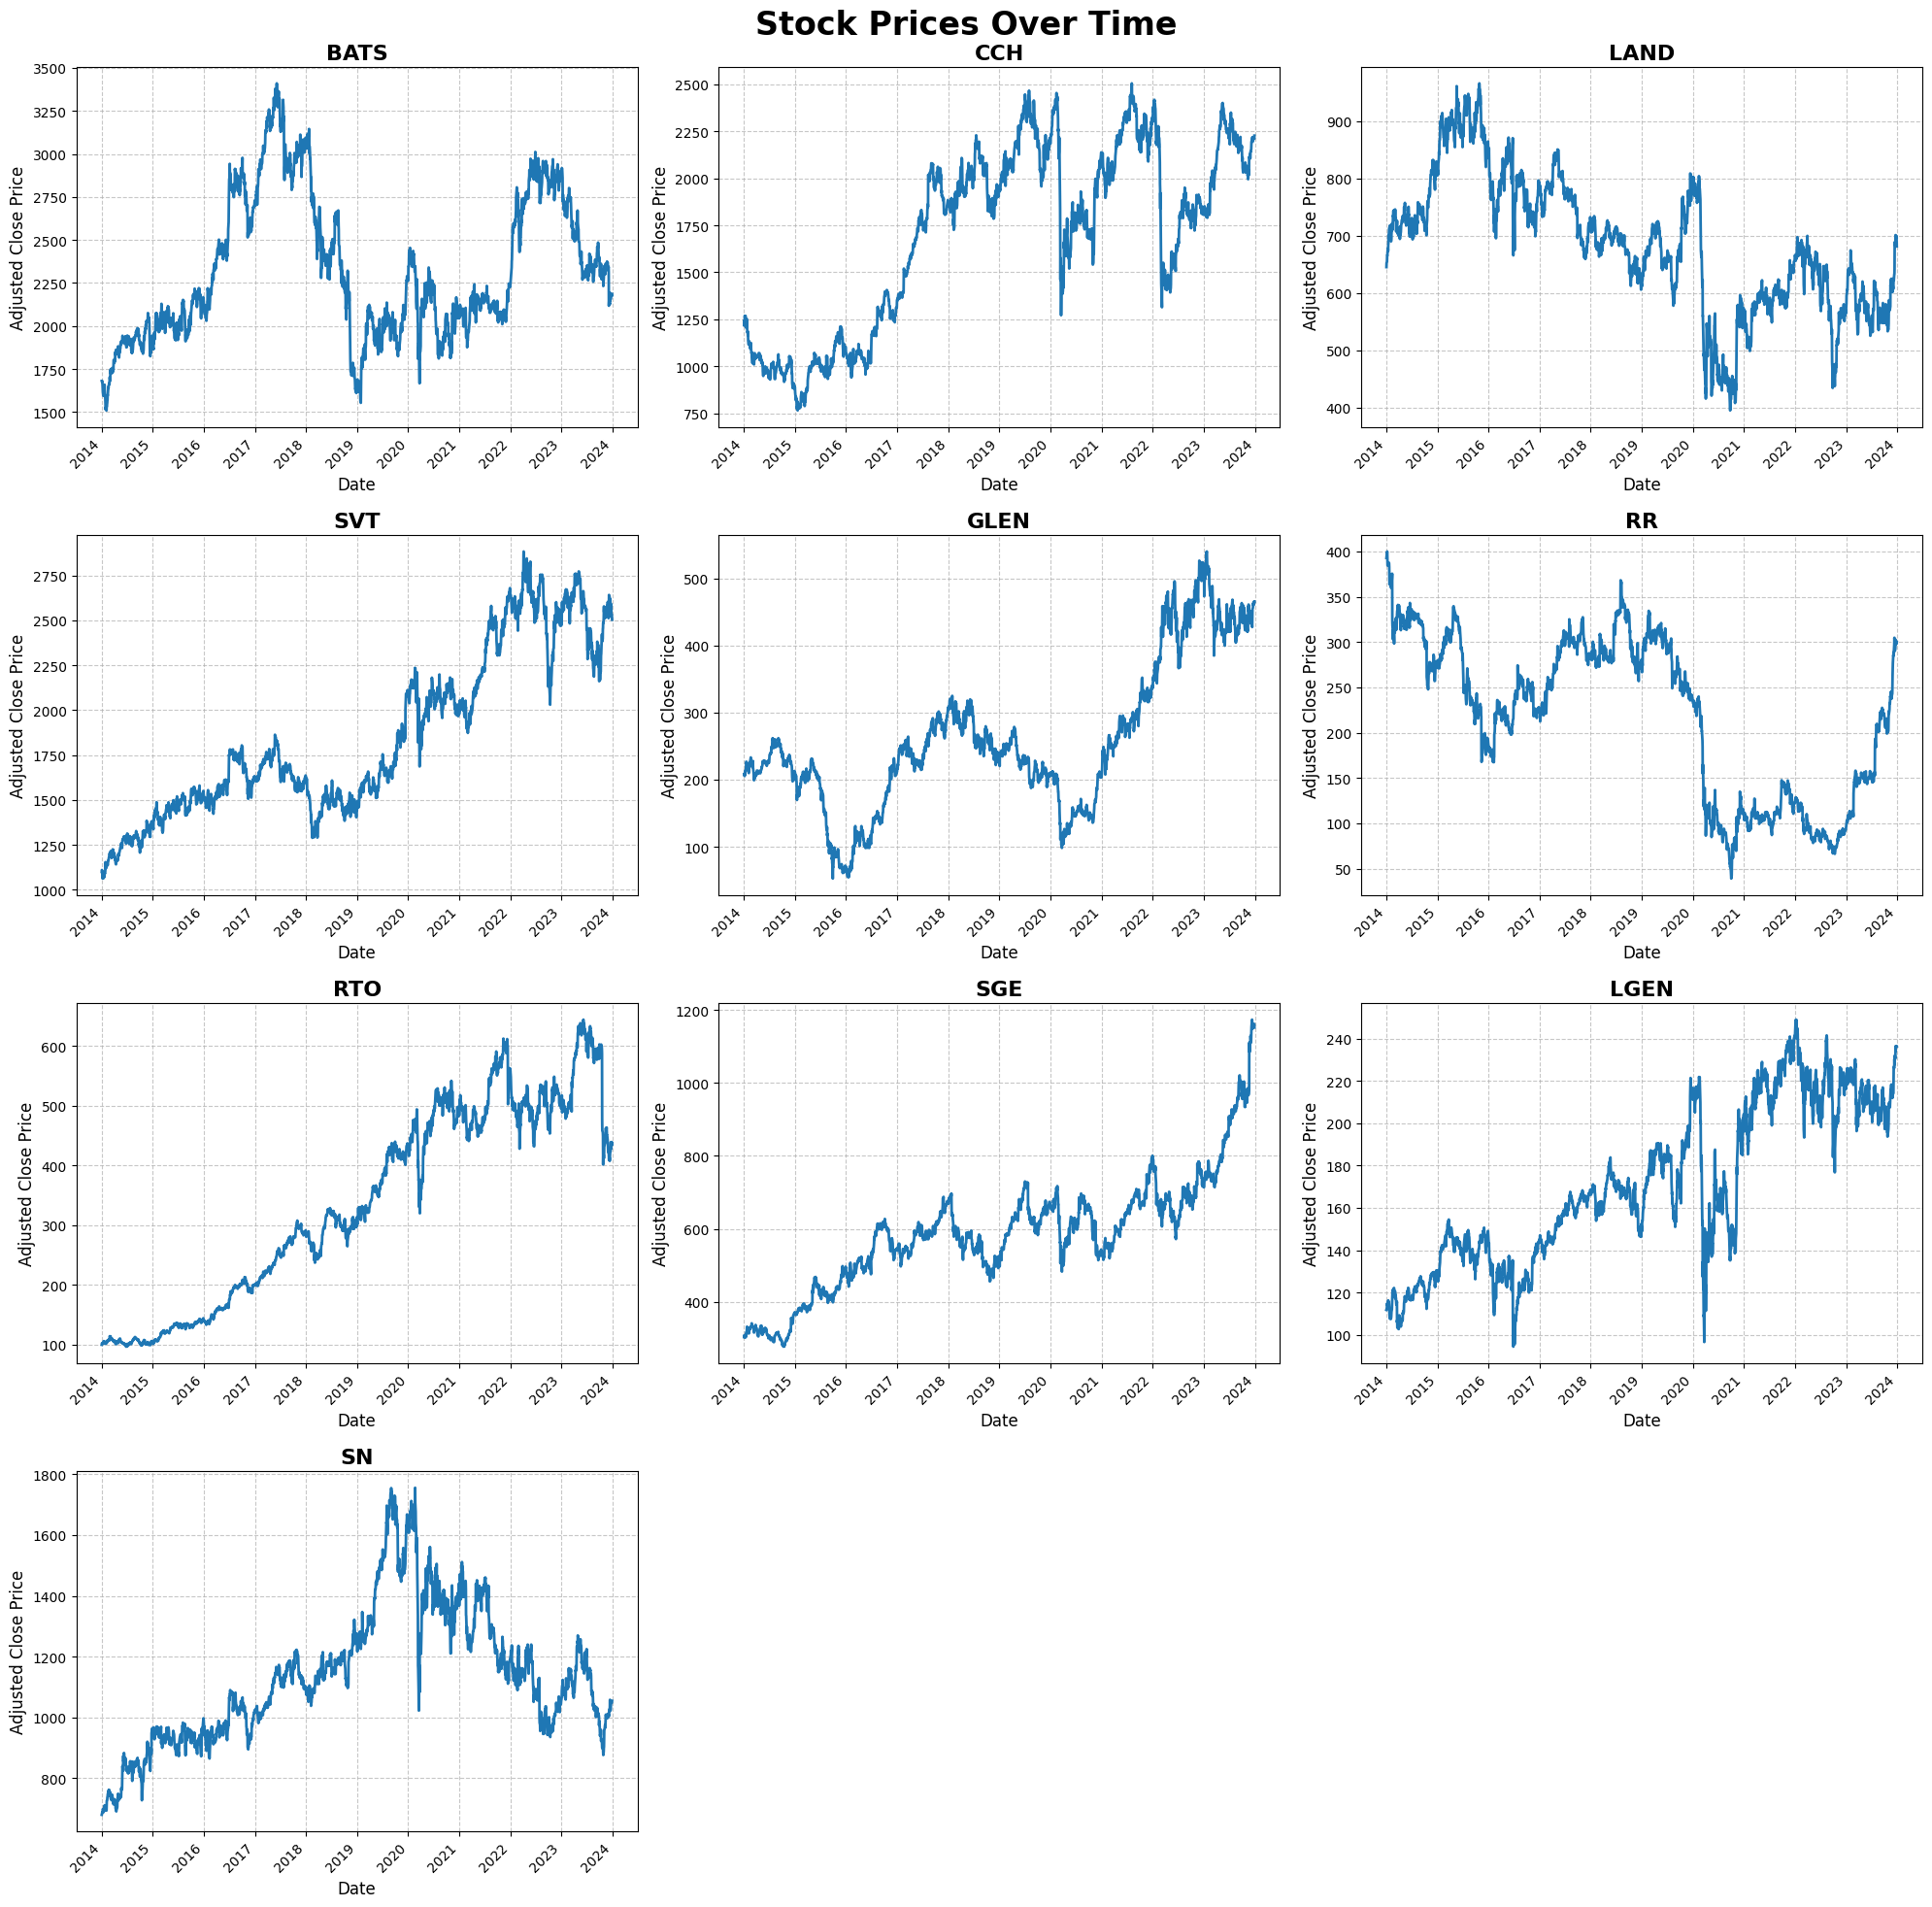

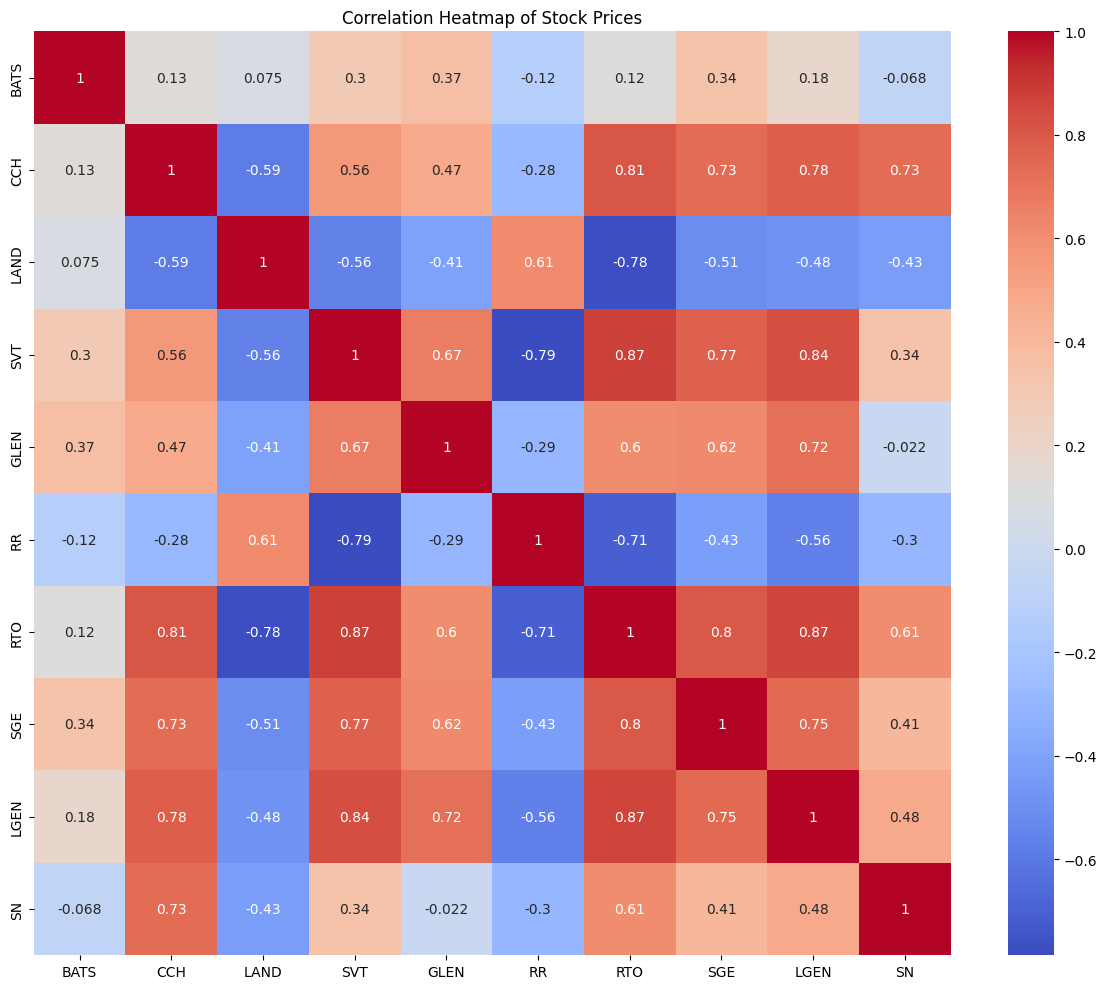


Sharpe Ratios:
BATS    0.112955
CCH     0.212082
LAND    0.019852
SVT     0.394571
GLEN    0.183335
RR     -0.057185
RTO     0.580292
SGE     0.555140
LGEN    0.240957
SN      0.177436
dtype: float64

Skewness:
BATS   -0.498487
CCH    -0.446974
LAND   -0.049744
SVT    -0.165230
GLEN   -0.861285
RR      0.891731
RTO    -1.084097
SGE    -0.624066
LGEN   -0.690206
SN     -0.044512
dtype: float64

Kurtosis:
BATS     5.081082
CCH     10.662331
LAND    13.138593
SVT      3.973697
GLEN    15.445738
RR      18.030487
RTO     21.138370
SGE     10.137101
LGEN    20.218394
SN      10.428996
dtype: float64


In [10]:

def perform_eda(merged_df):
    """
    Perform exploratory data analysis (EDA) on the dataset.

    Parameters:
    - merged_df (pd.DataFrame): Merged DataFrame containing stock price
      data for multiple stocks.

    Returns:
    - dict: Dictionary containing EDA results such as correlations,
      Sharpe ratios, skewness, and kurtosis.
    """
    # Initialize a dictionary to store results
    results = {}

    # Check for missing values
    print('\nMissing values:')
    print(merged_df.isnull().sum())  # Print the count of missing values

    # Check for duplicate rows and print number of duplicate rows
    print('\nDuplicate rows:')
    print(merged_df.duplicated().sum())  # Print the count of duplicate rows

    # Print summary statistics for the DataFrame
    print("\nDescriptive Statistics:")
    print(merged_df.describe())  # Print summary statistics

    # Calculate the number of stocks (excluding the Date column)
    n_stocks = len(merged_df.columns) - 1

    # Calculate the number of rows and columns for subplots
    n_cols = 3  # You can adjust this
    n_rows = (n_stocks - 1) // n_cols + 1

    # Create a large figure for stock prices over time
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    fig.suptitle('Stock Prices Over Time', fontsize=24, fontweight='bold')

    # Flatten the axs array for easier indexing
    axs = axs.flatten()

    # Plot each stock in a separate subplot
    for i, column in enumerate(merged_df.columns):
        if column != 'Date':
            ax = axs[i - 1]  # Subtract 1 because we skip the Date column
            ax.plot(merged_df['Date'], merged_df[column], linewidth=2)
            ax.set_title(column, fontsize=16, fontweight='bold')
            ax.set_xlabel('Date', fontsize=12)
            ax.set_ylabel('Adjusted Close Price', fontsize=12)

            # Improve x-axis date formatting
            ax.xaxis.set_major_locator(mdates.YearLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

            ax.grid(True, linestyle='--', alpha=0.7)
            ax.tick_params(axis='both', which='major', labelsize=10)

    # Remove any unused subplots
    for j in range(i, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.subplots_adjust(top=0.95)  # Adjust to make room for suptitle
    plt.show()

    # Calculate correlation heatmap
    corr = merged_df.drop('Date', axis=1).corr()  # Calculate correlation
    results['corr'] = corr  # Store the correlation matrix in results
    plt.figure(figsize=(12, 10))  # Set the figure size
    sns.heatmap(corr, annot=True, cmap='coolwarm')  # Plot heatmap
    plt.title('Correlation Heatmap of Stock Prices')  # Set plot title
    plt.tight_layout()  # Adjust layout to fit everything
    plt.show()  # Display the plot

    # Calculate log returns
    log_ret = np.log(merged_df.drop('Date', axis=1)).diff().dropna()
    results['avg_log_ret'] = log_ret.mean()  # Store average log returns

    # Calculate additional statistics
    ann_ret = log_ret.mean() * 252
    ann_vol = log_ret.std() * np.sqrt(252)
    results['sharpe'] = ann_ret / ann_vol
    results['skew'] = log_ret.skew()
    results['kurt'] = log_ret.kurtosis()

    return results

# Set random seeds for reproducibility
set_random_seeds()

# Perform EDA and store the results
eda_results = perform_eda(merged_df)

# Print EDA results
print("\nSharpe Ratios:")
print(eda_results['sharpe'])
print("\nSkewness:")
print(eda_results['skew'])
print("\nKurtosis:")
print(eda_results['kurt'])


## Data Preprocessing Function

This step includes handling missing values, normalizing the data, adding technical indicators, creating lagged features, handling outliers, and optionally applying PCA for dimensionality reduction.

Random seeds set to 42 for reproducibility.


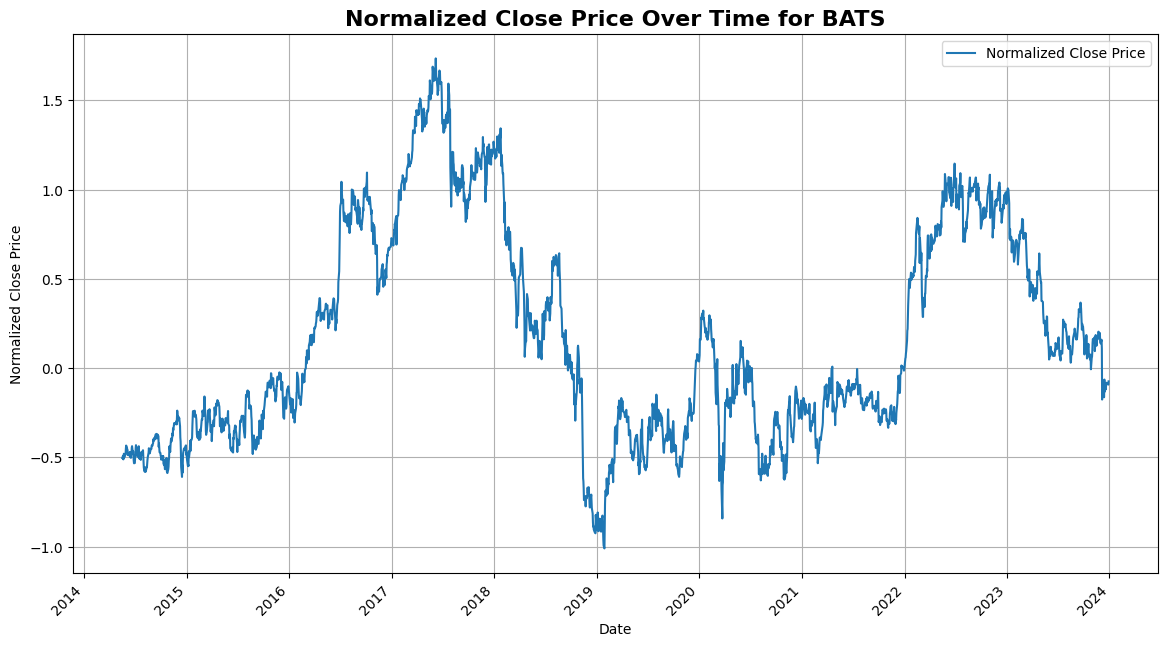

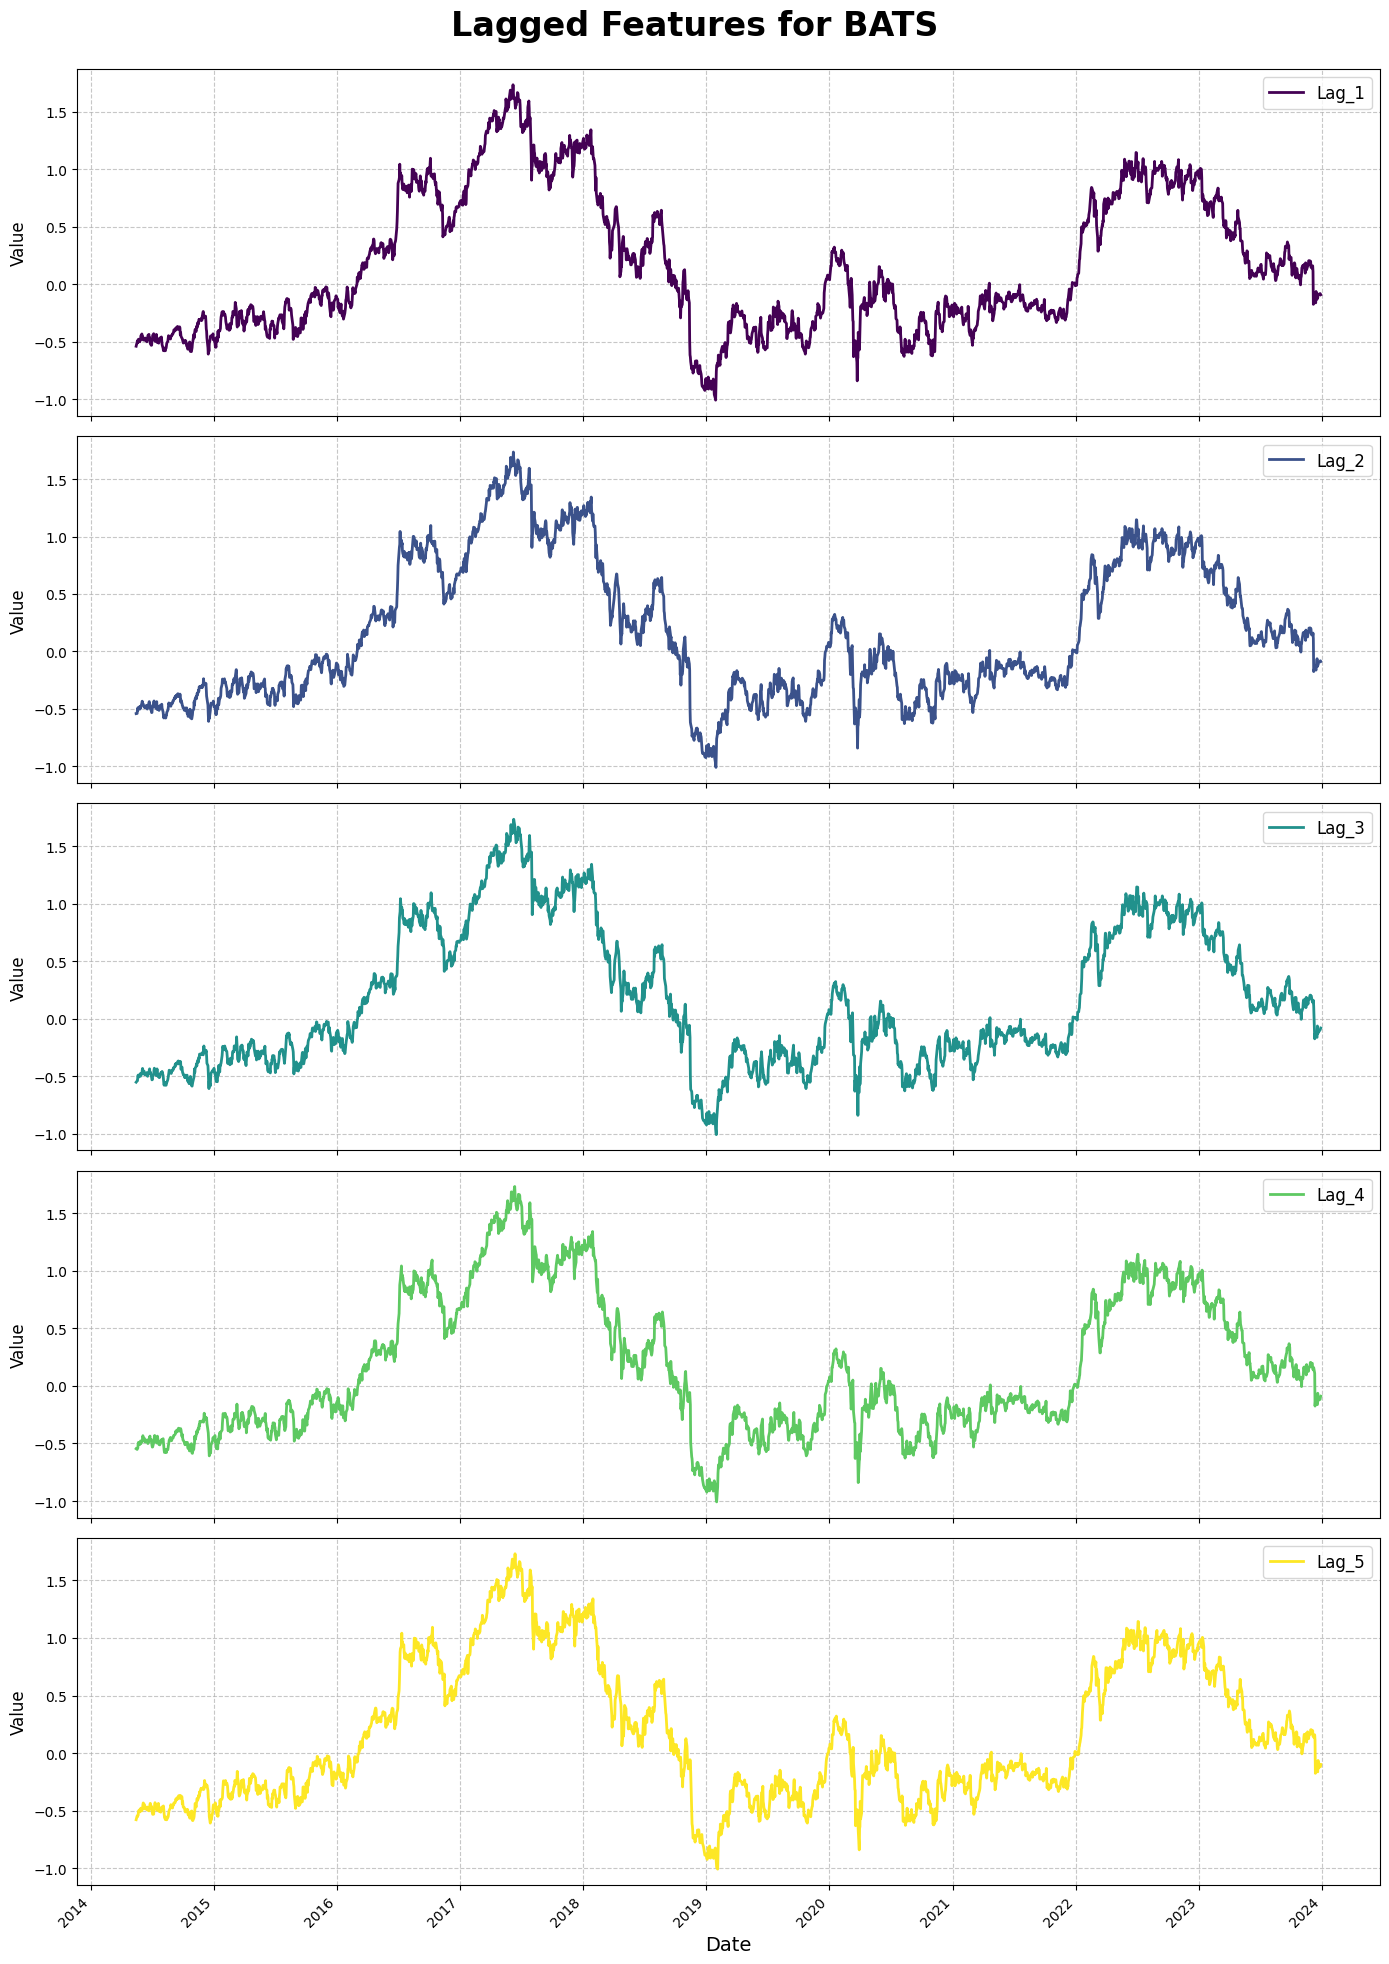

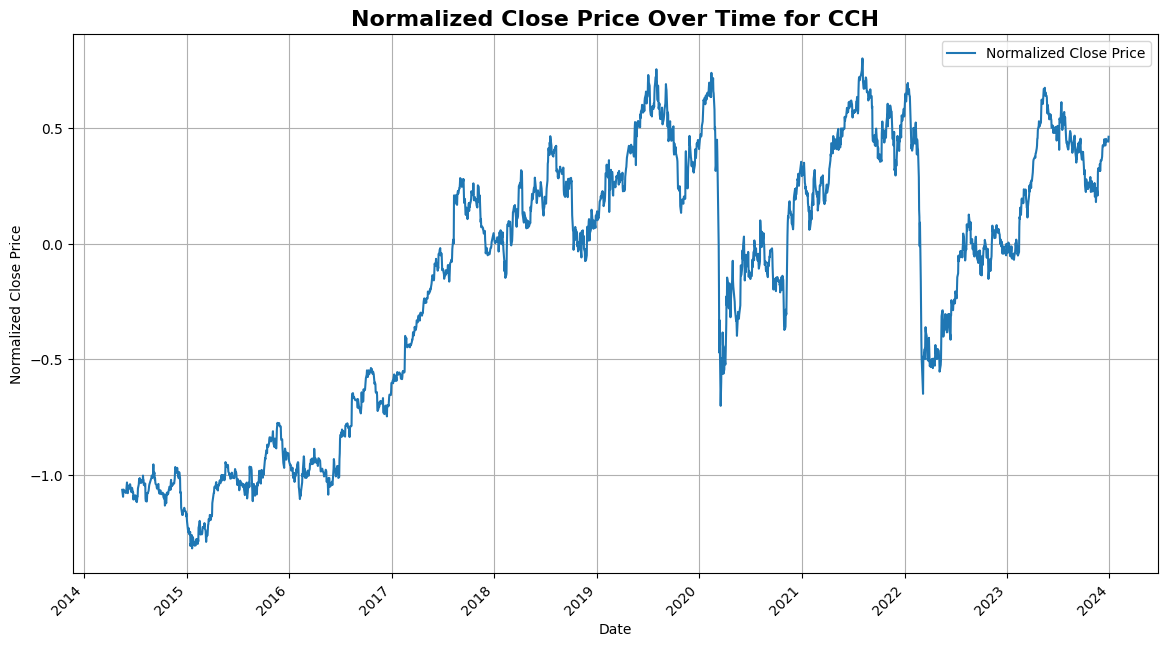

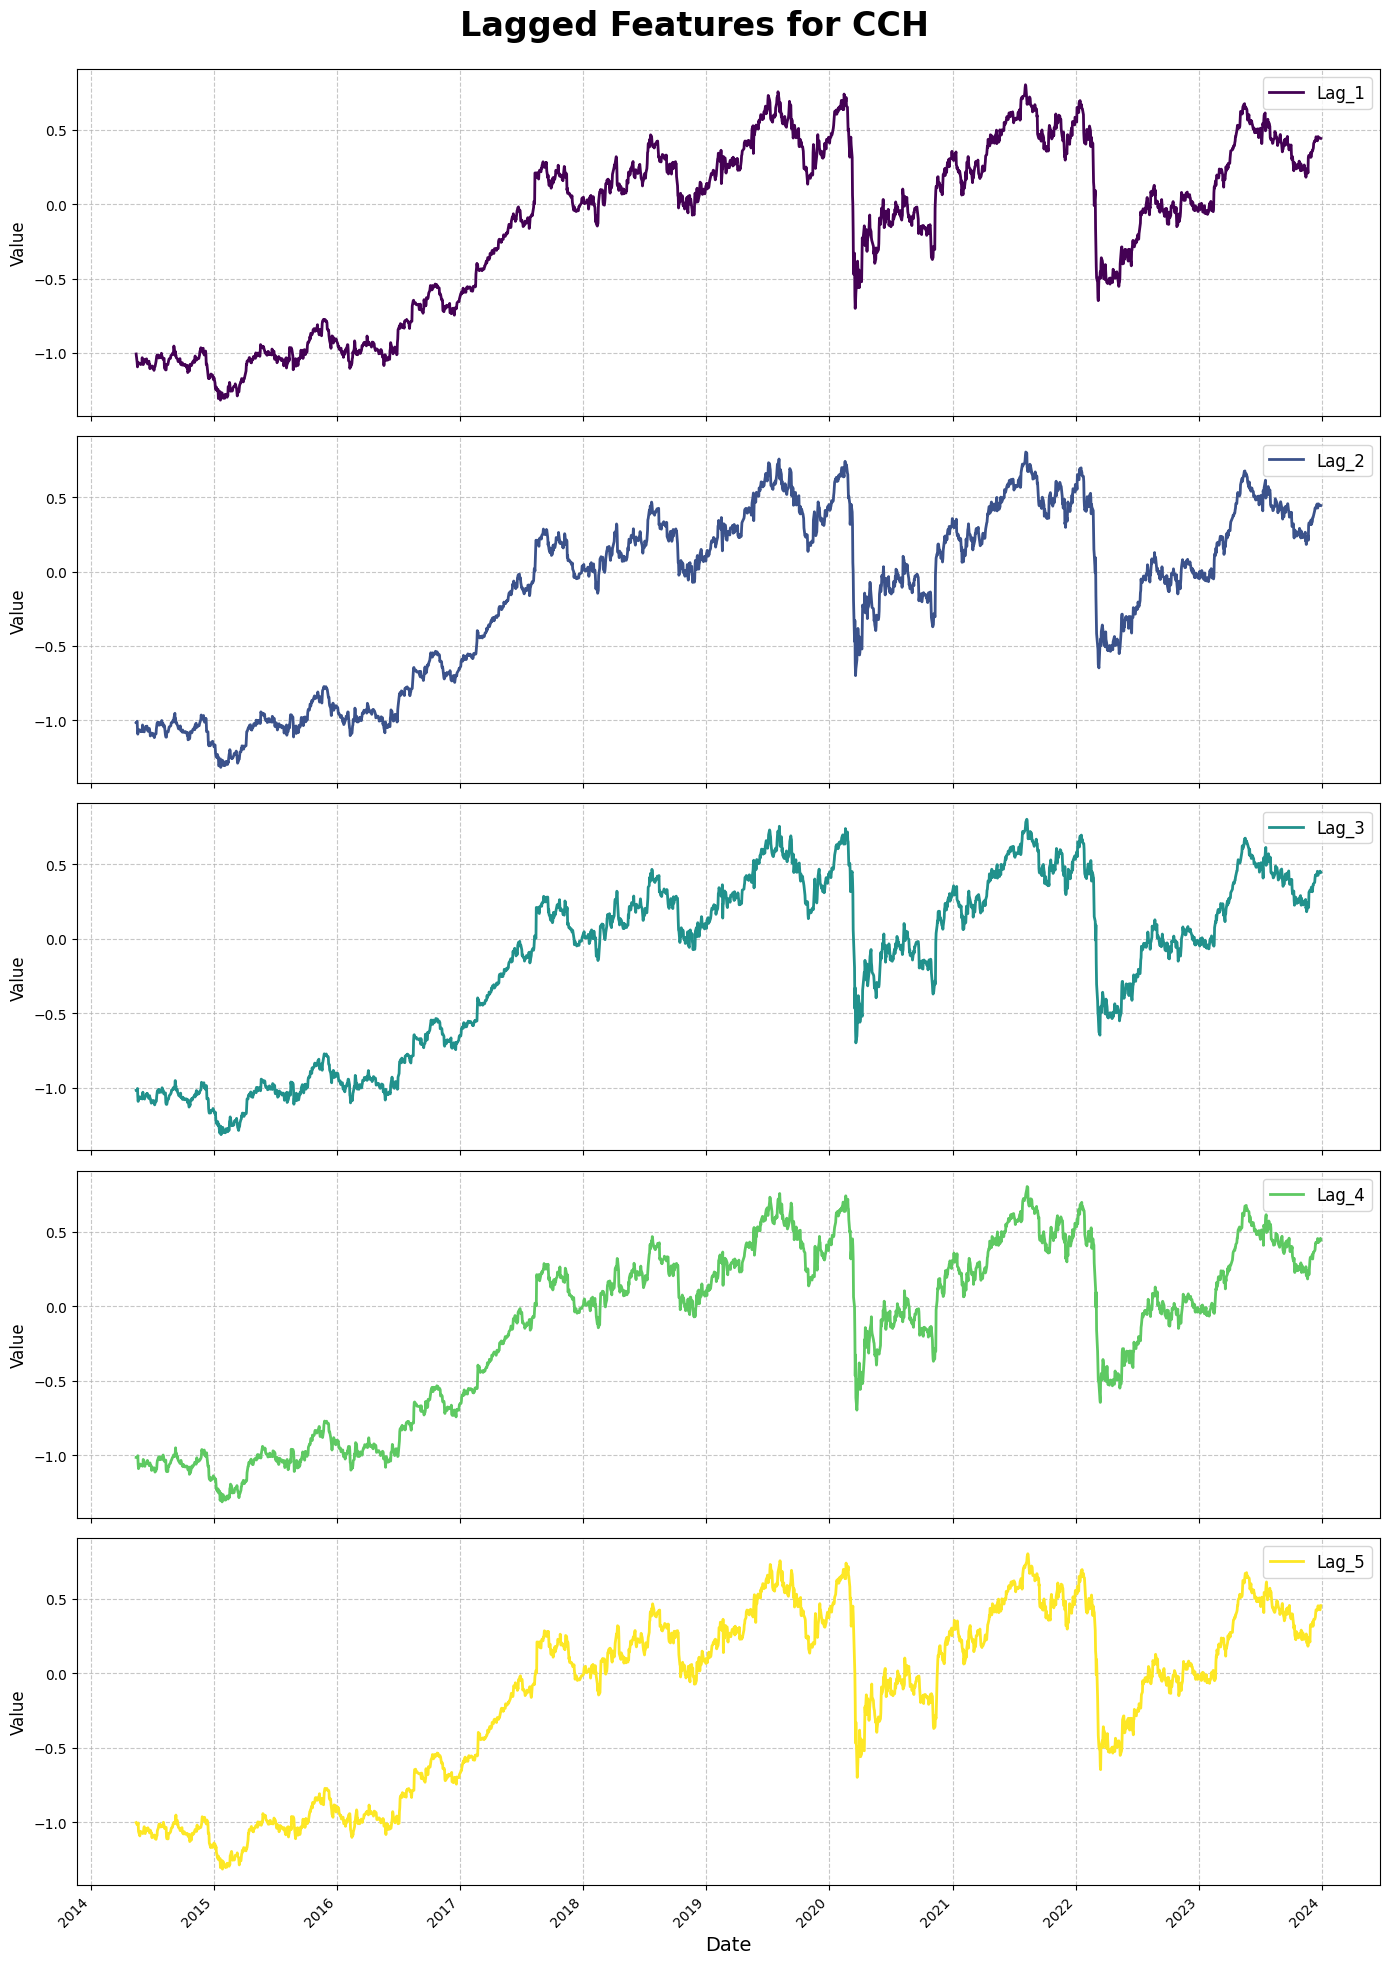

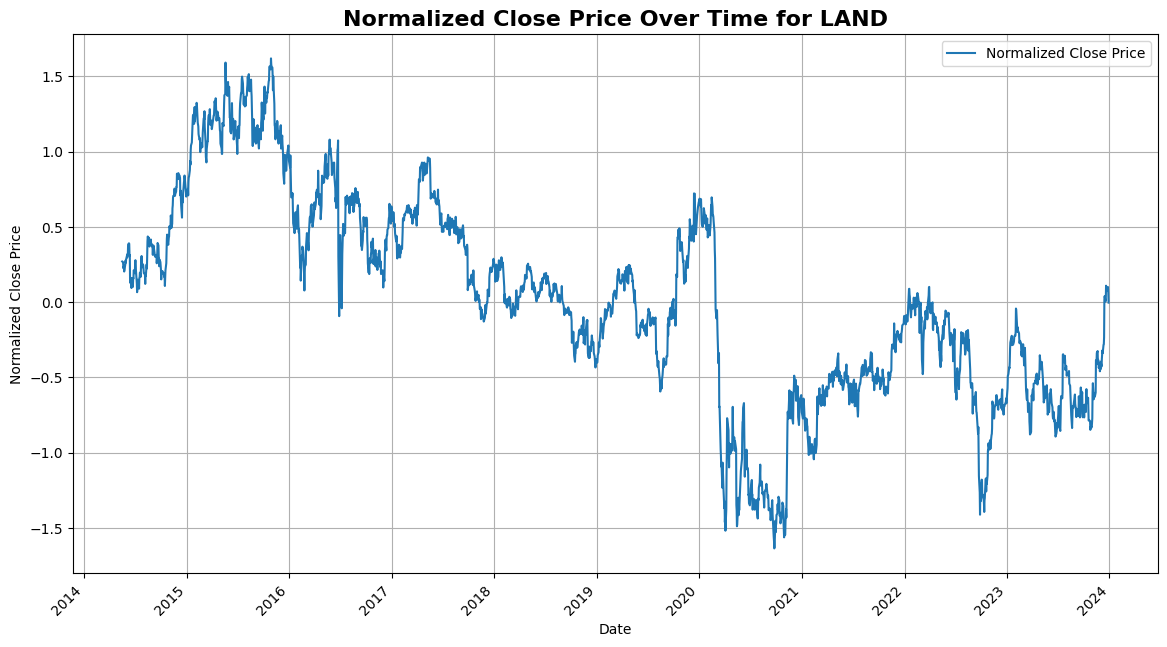

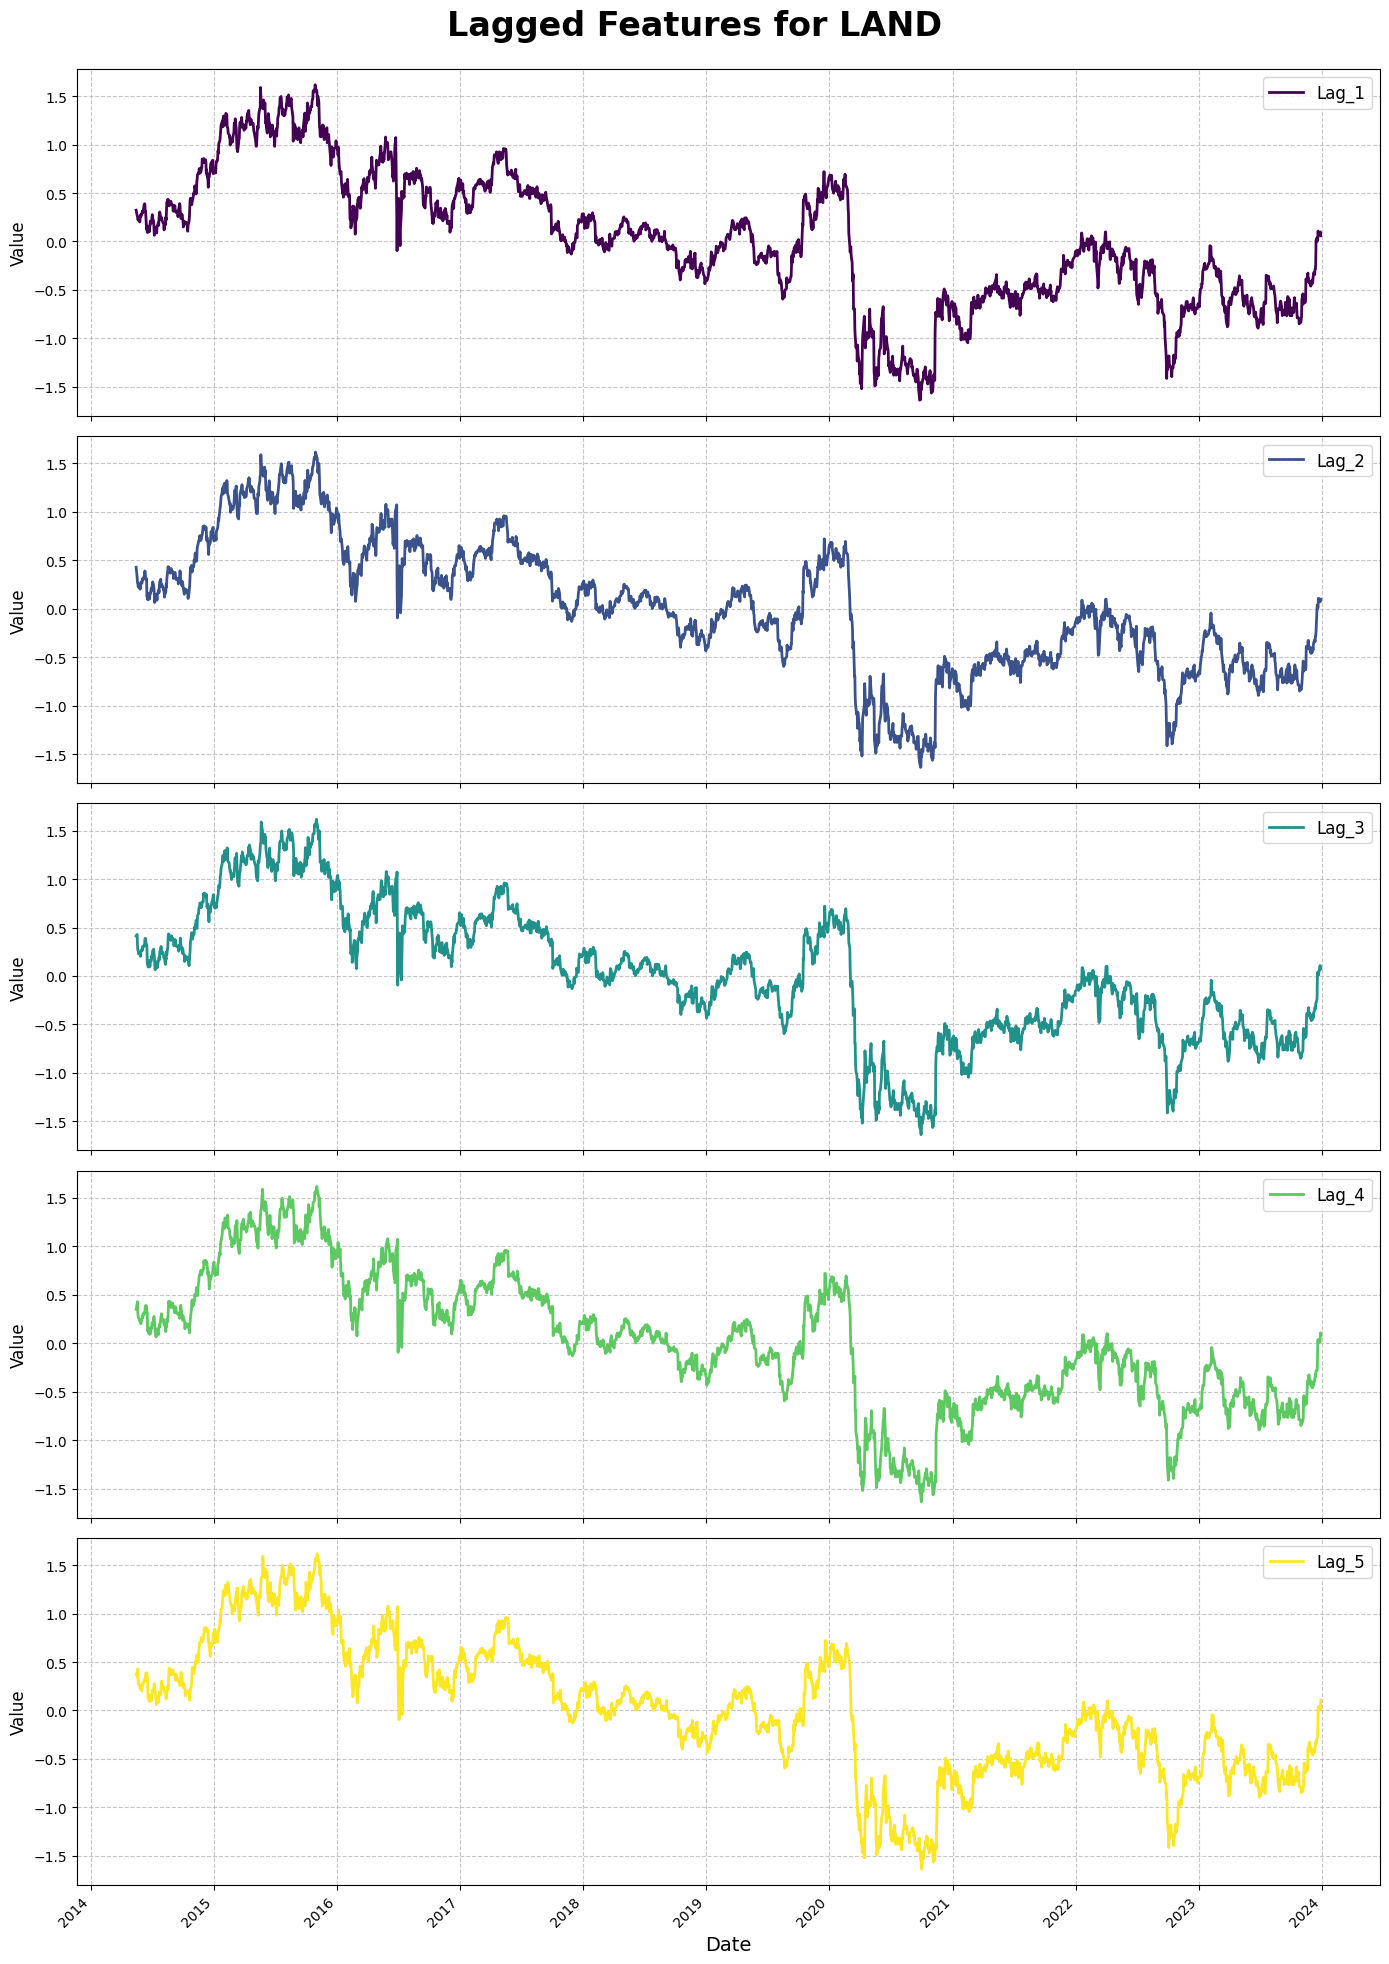

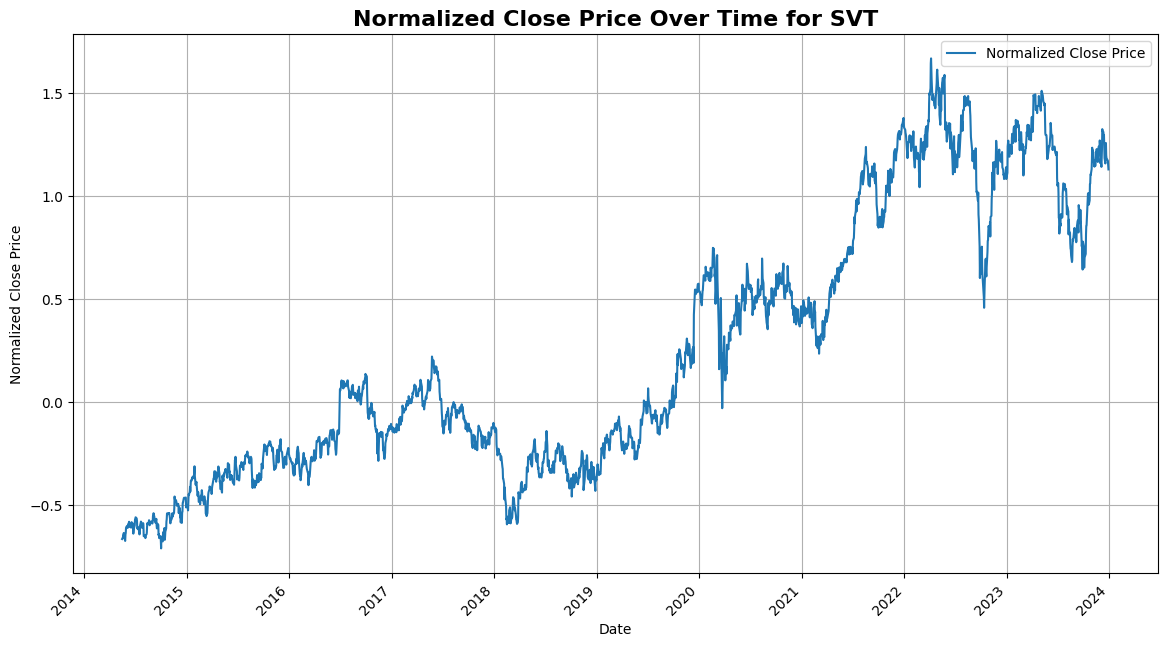

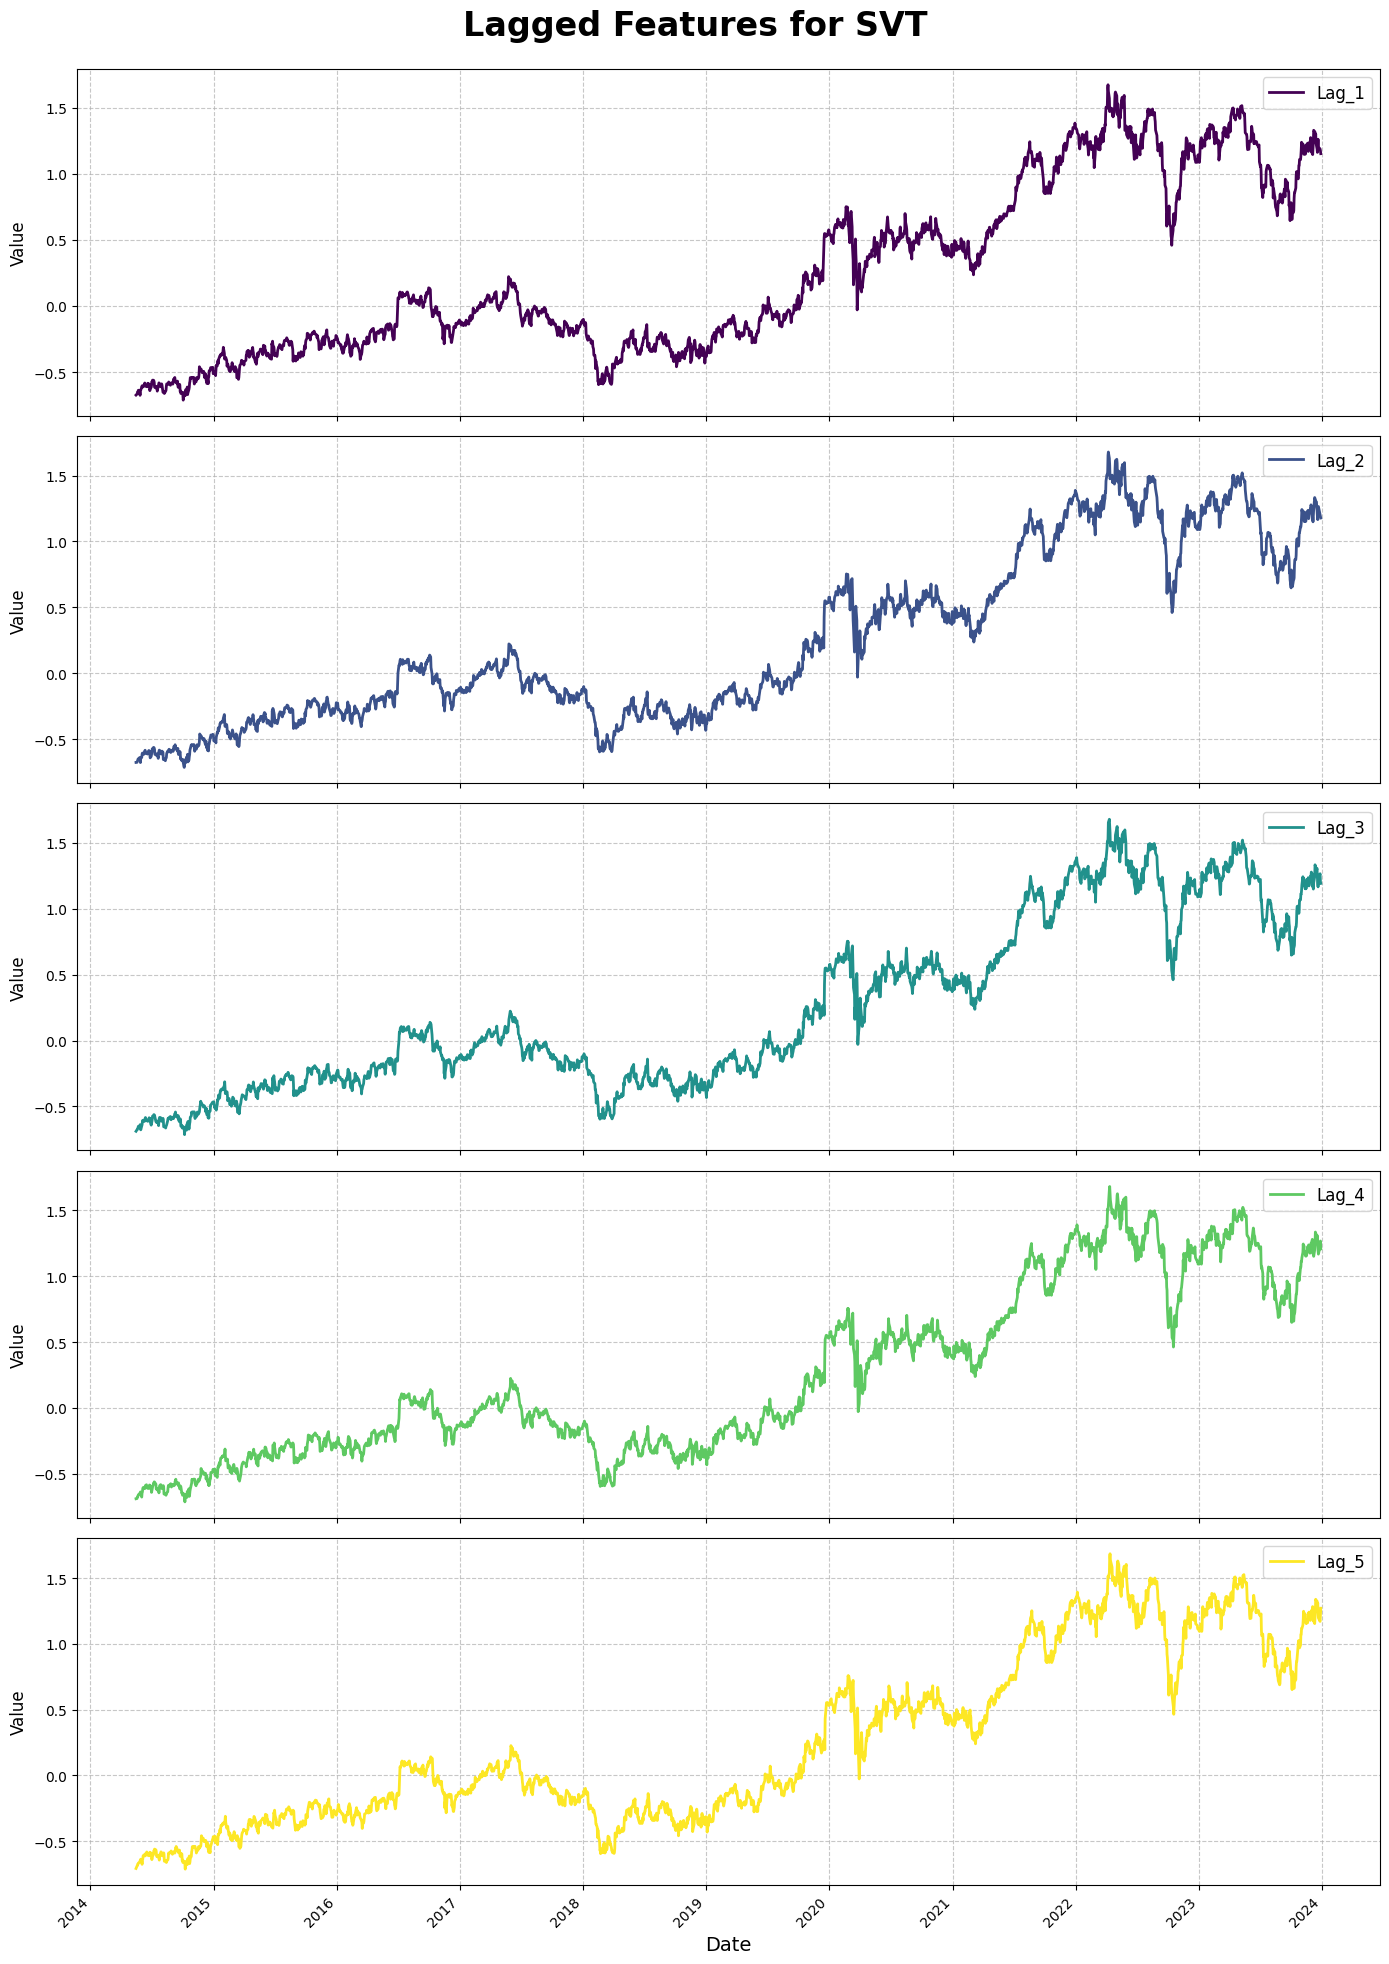

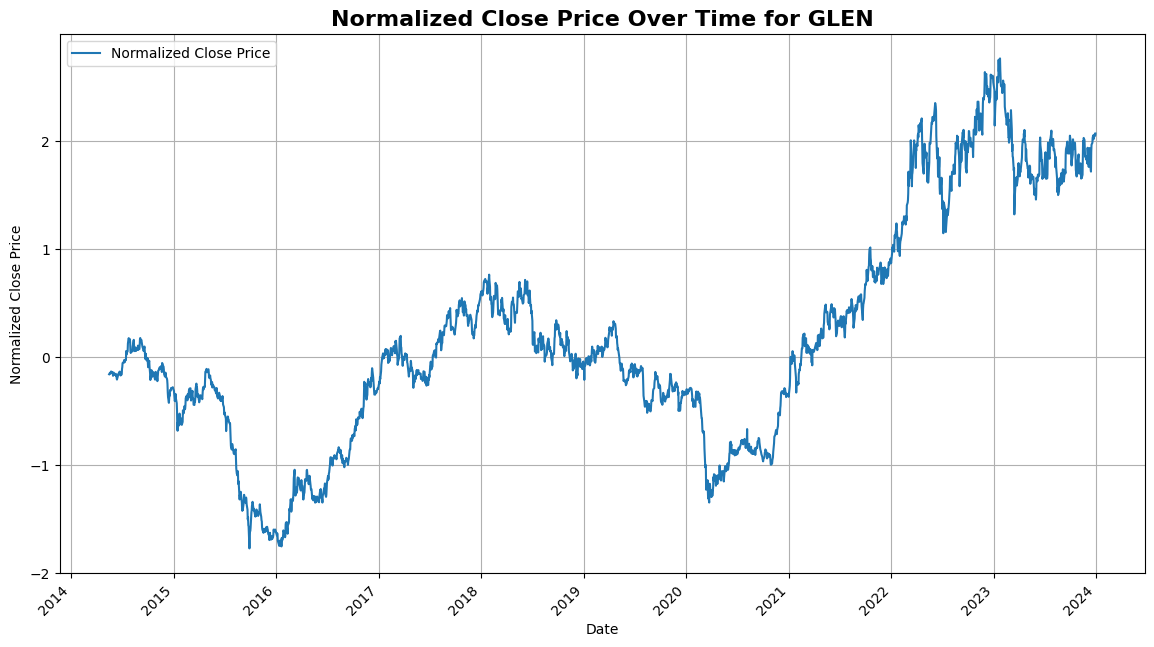

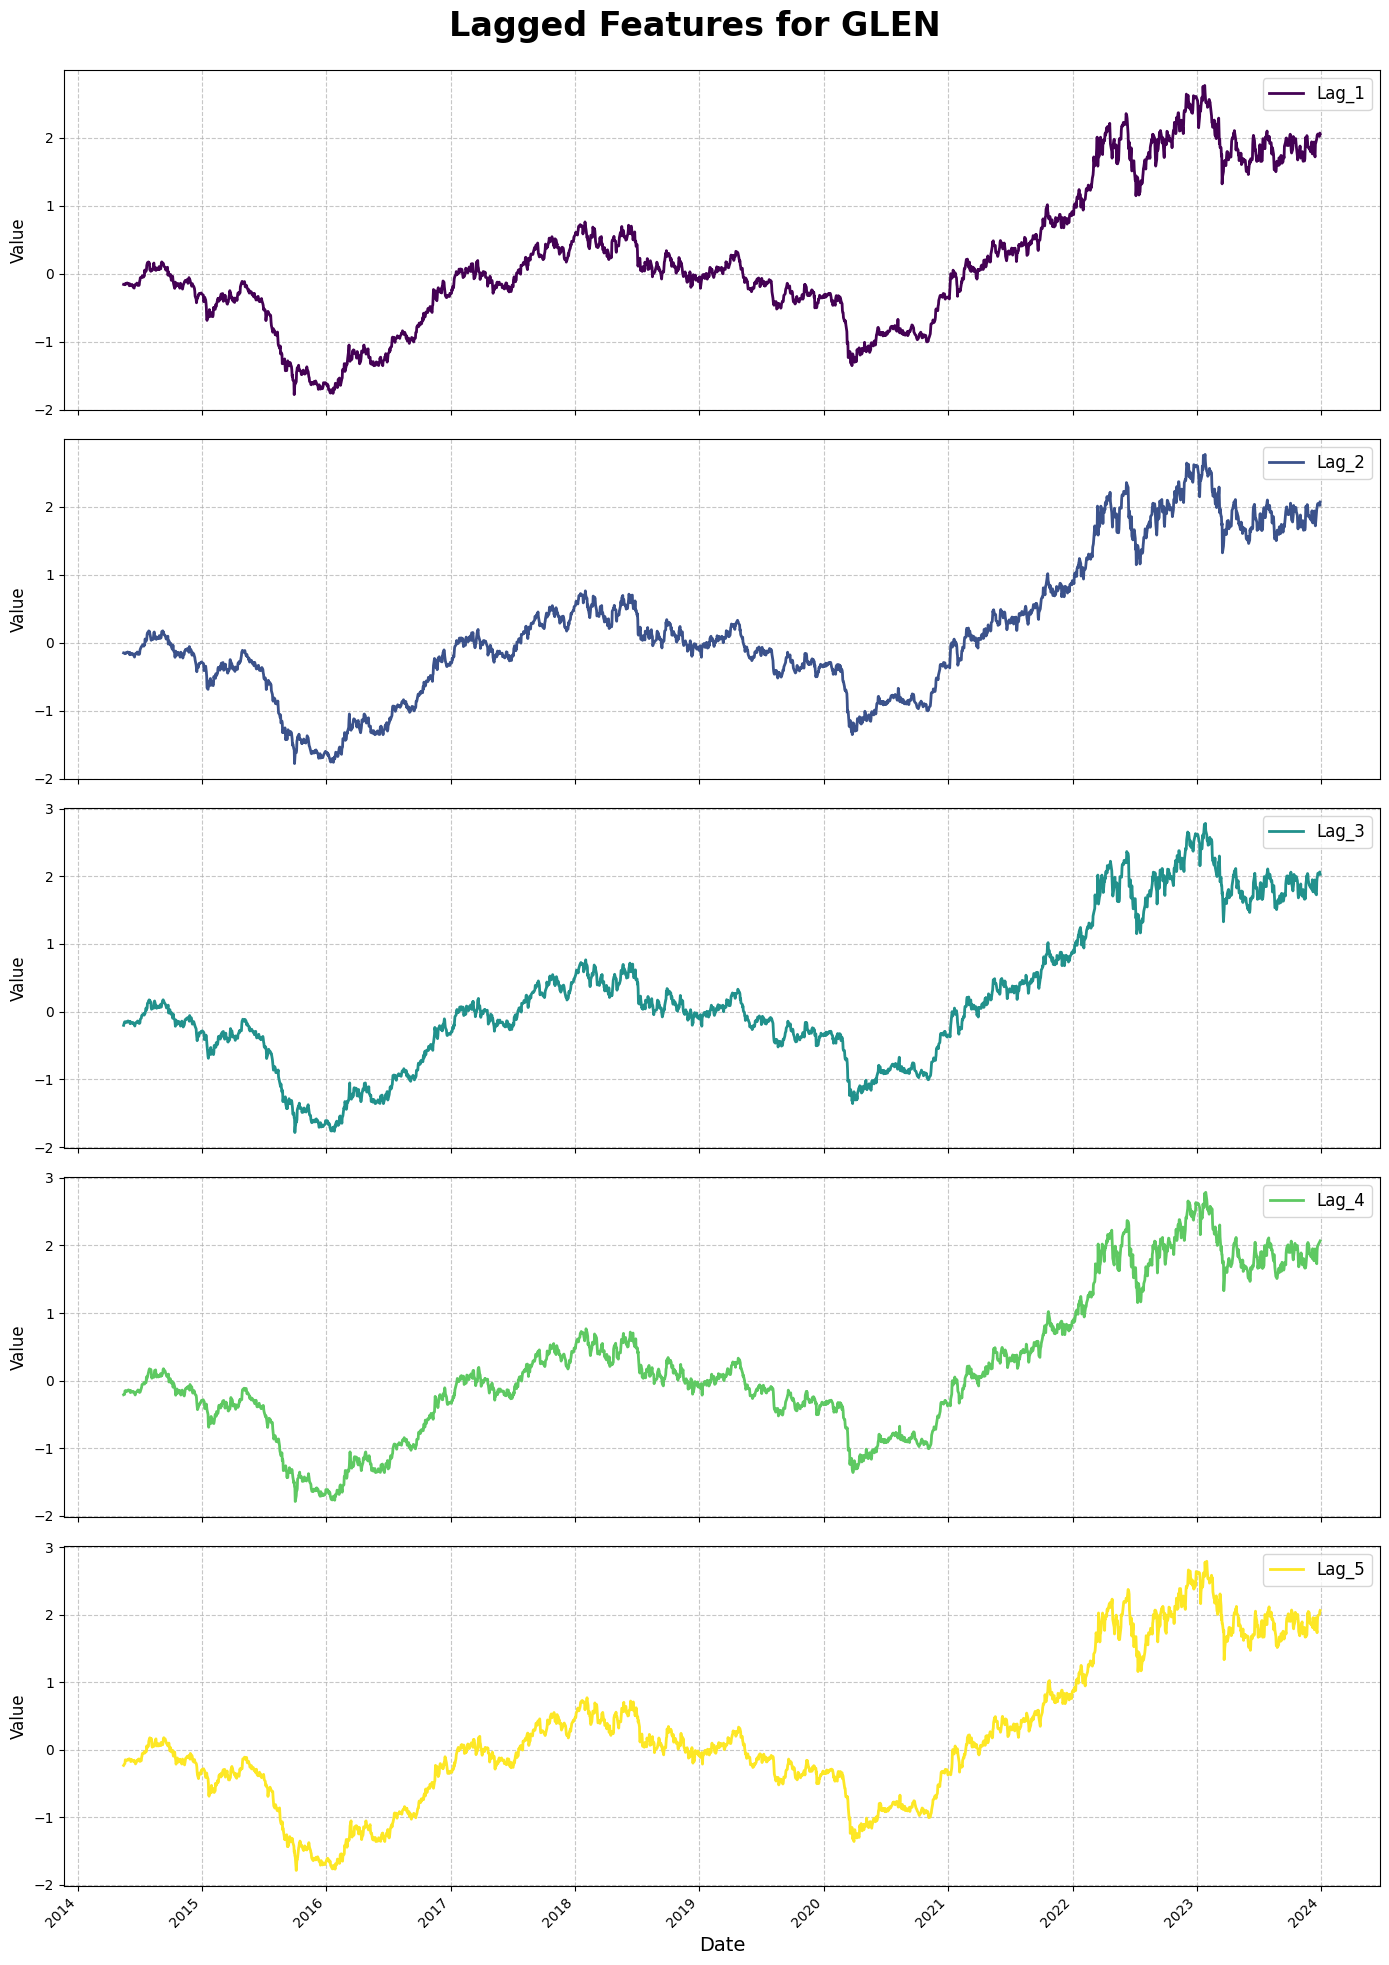

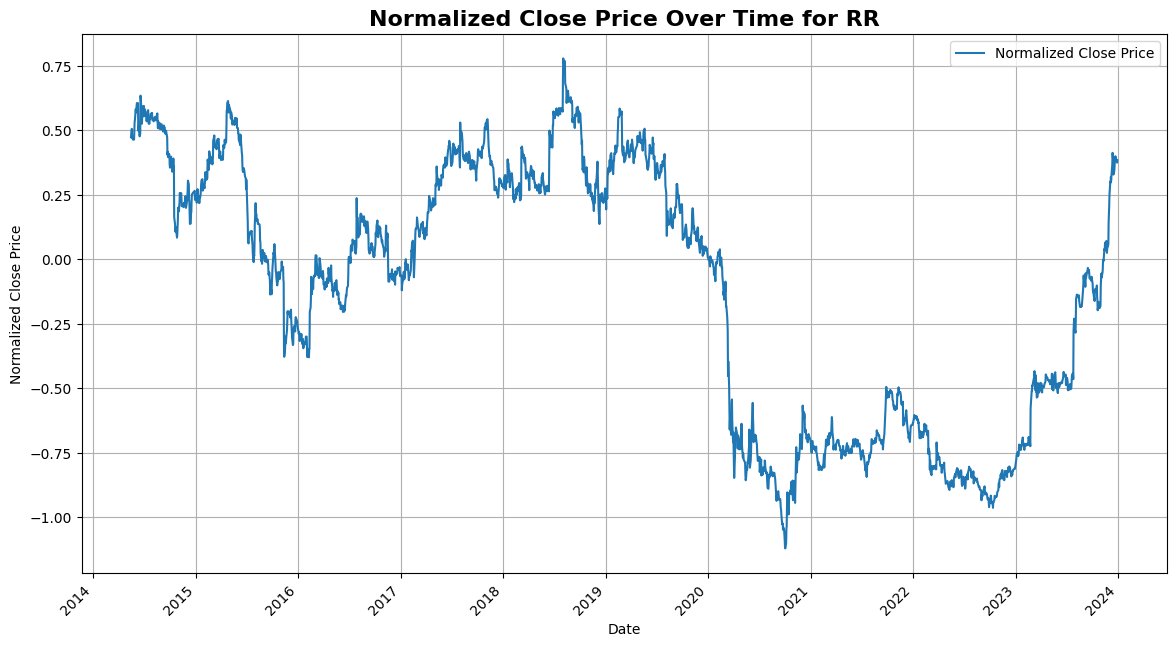

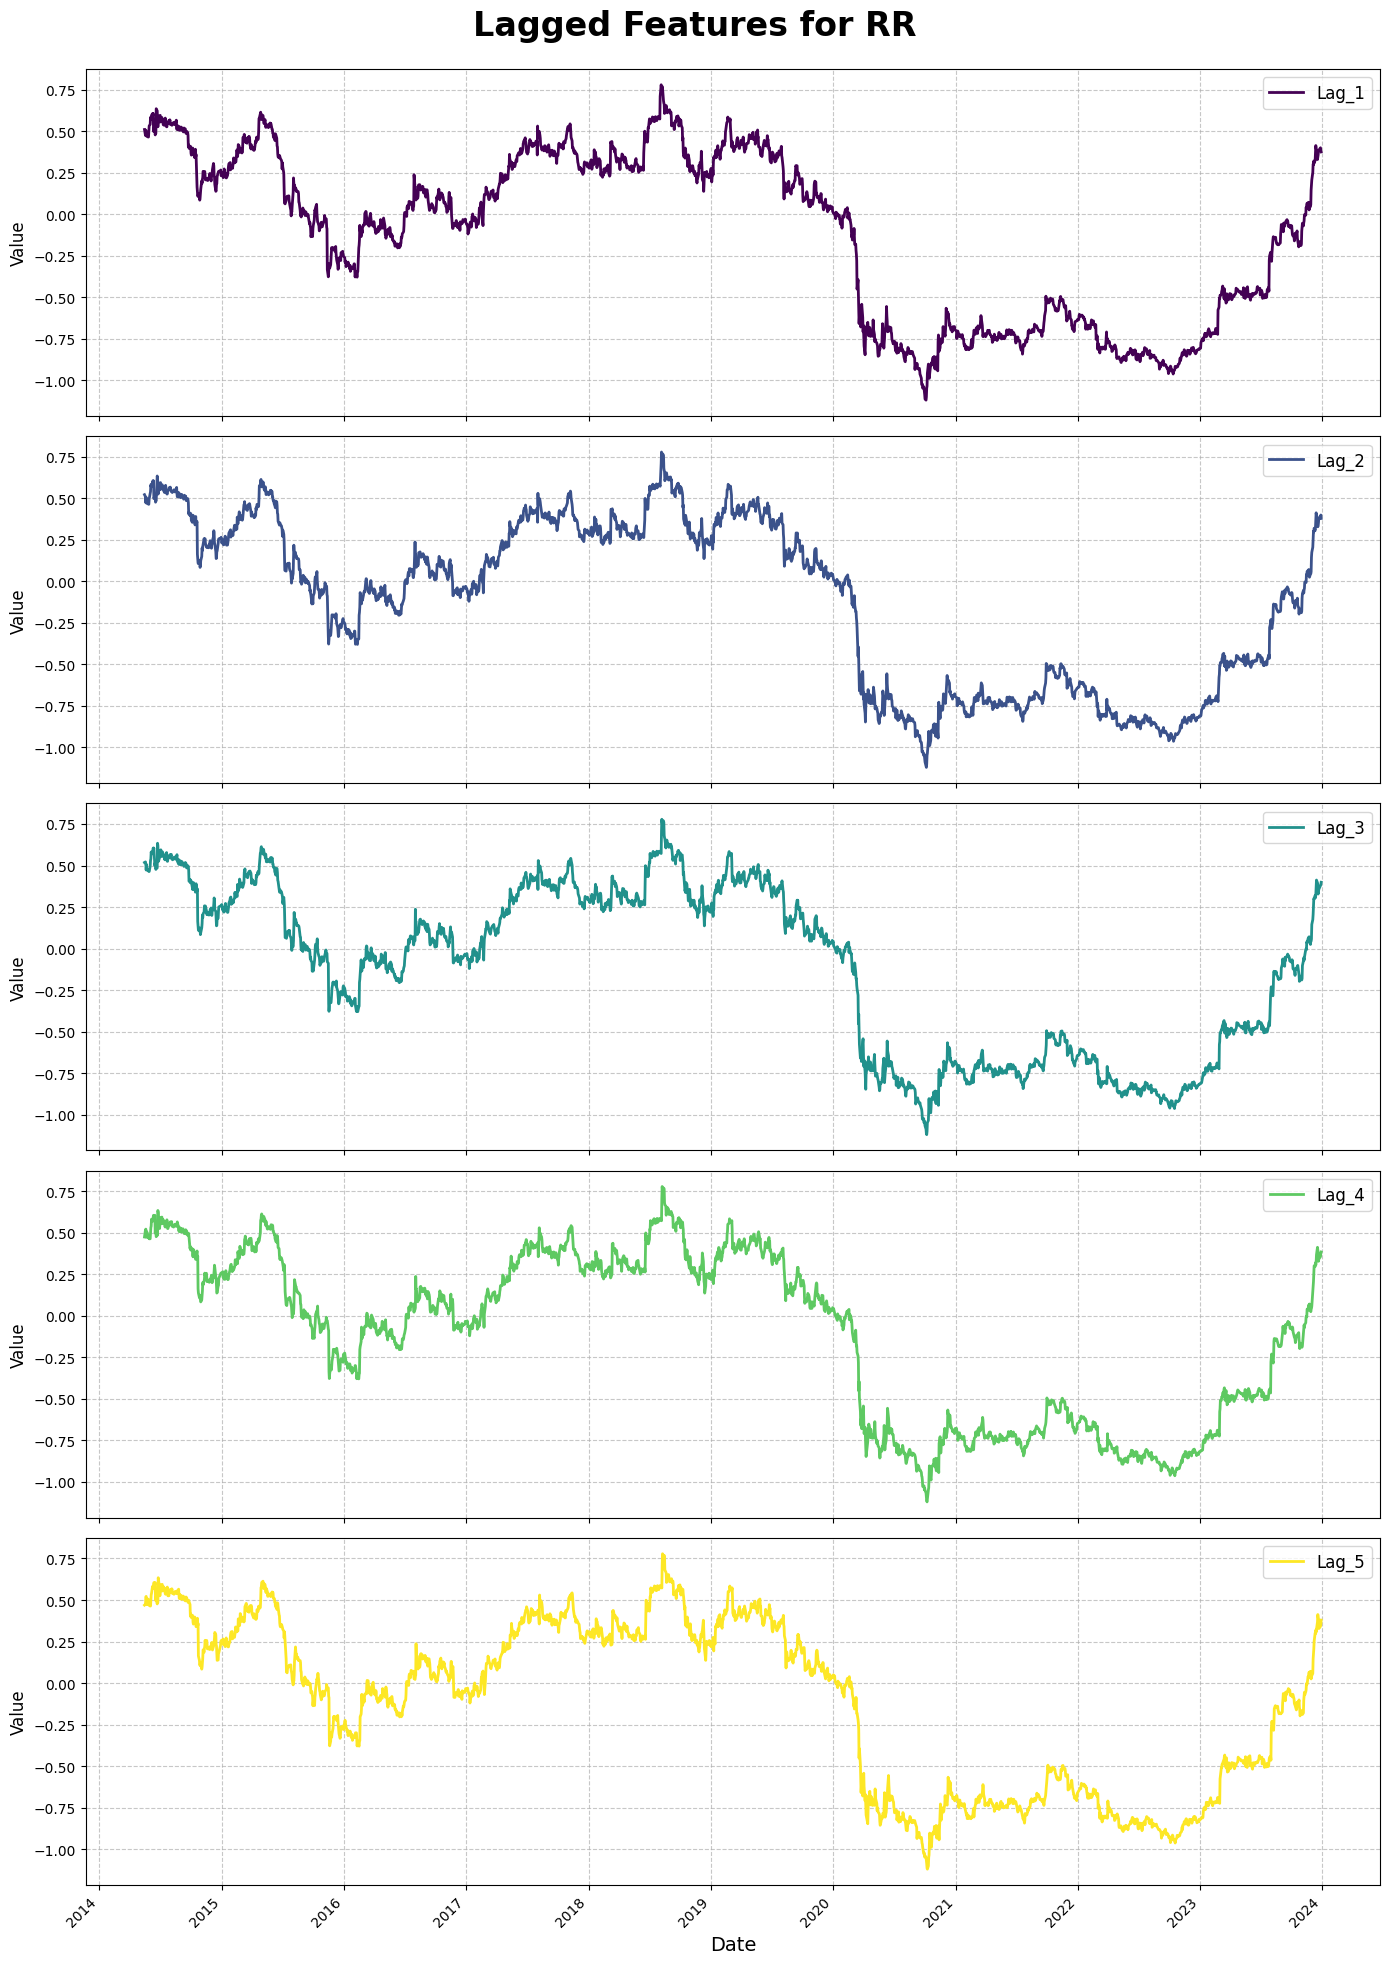

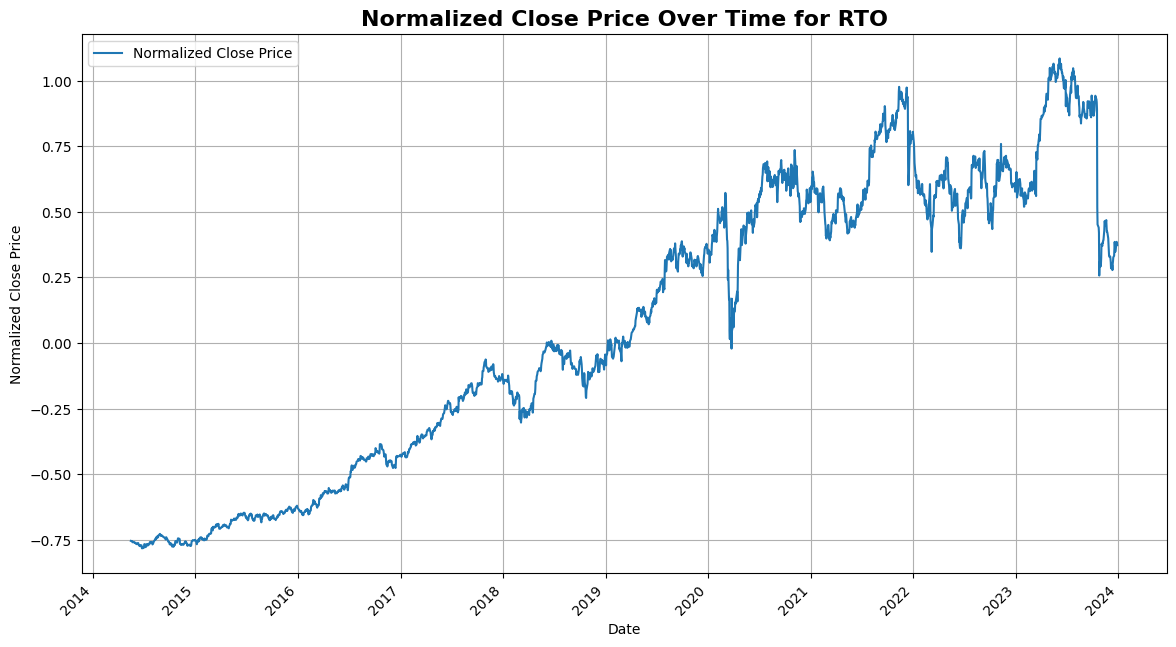

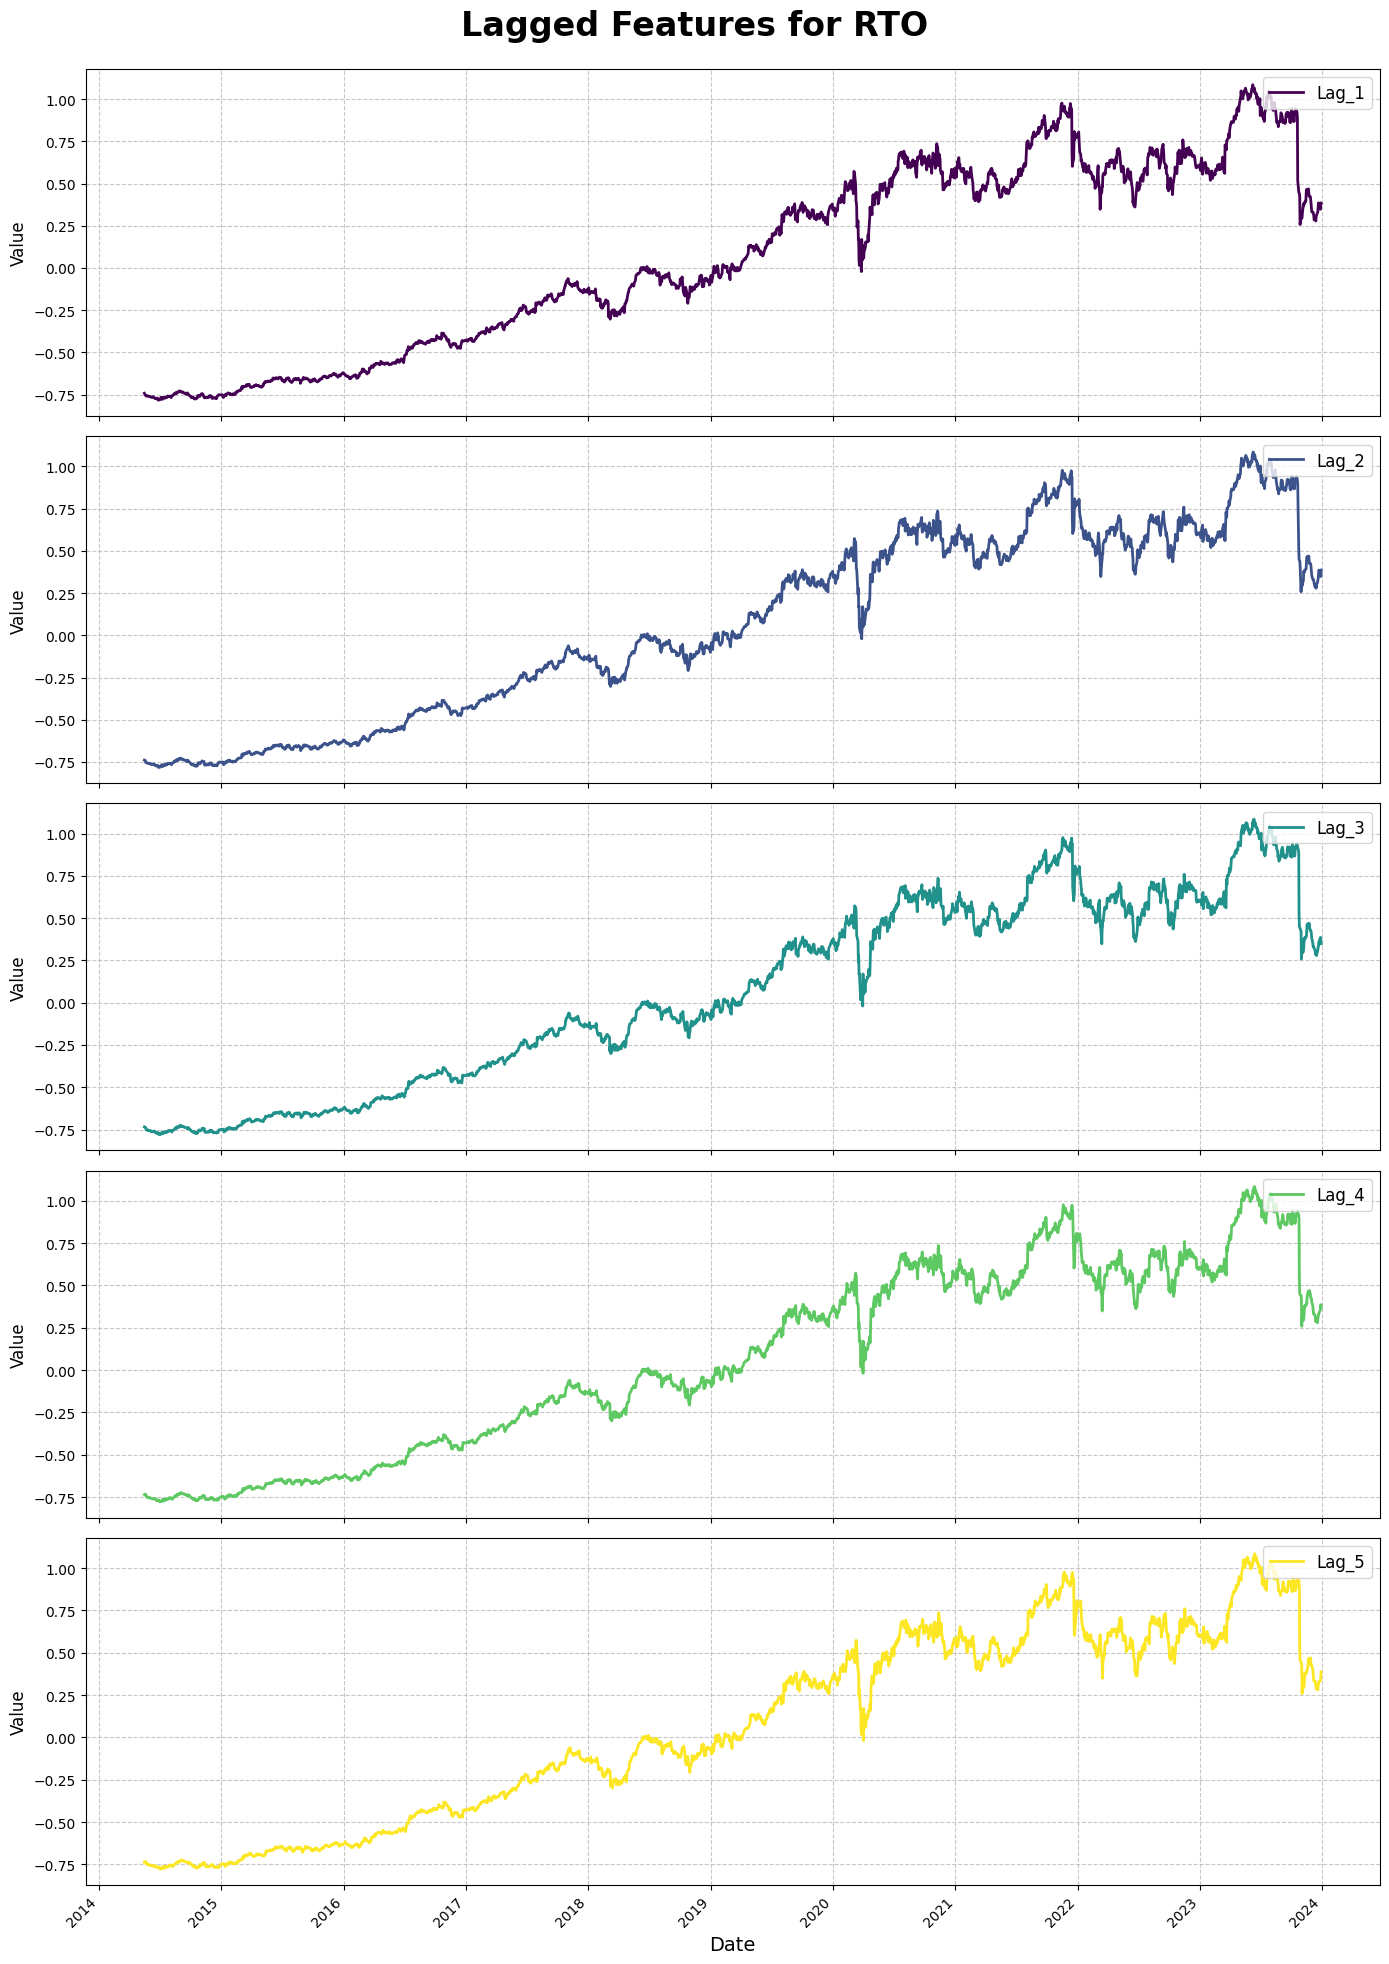

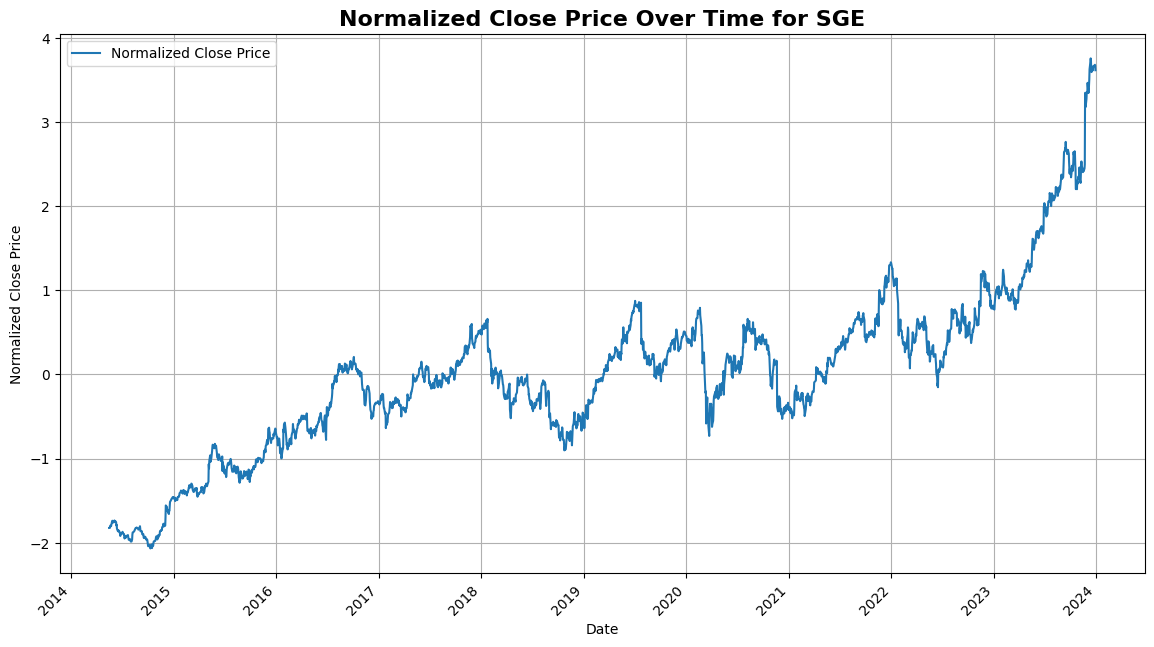

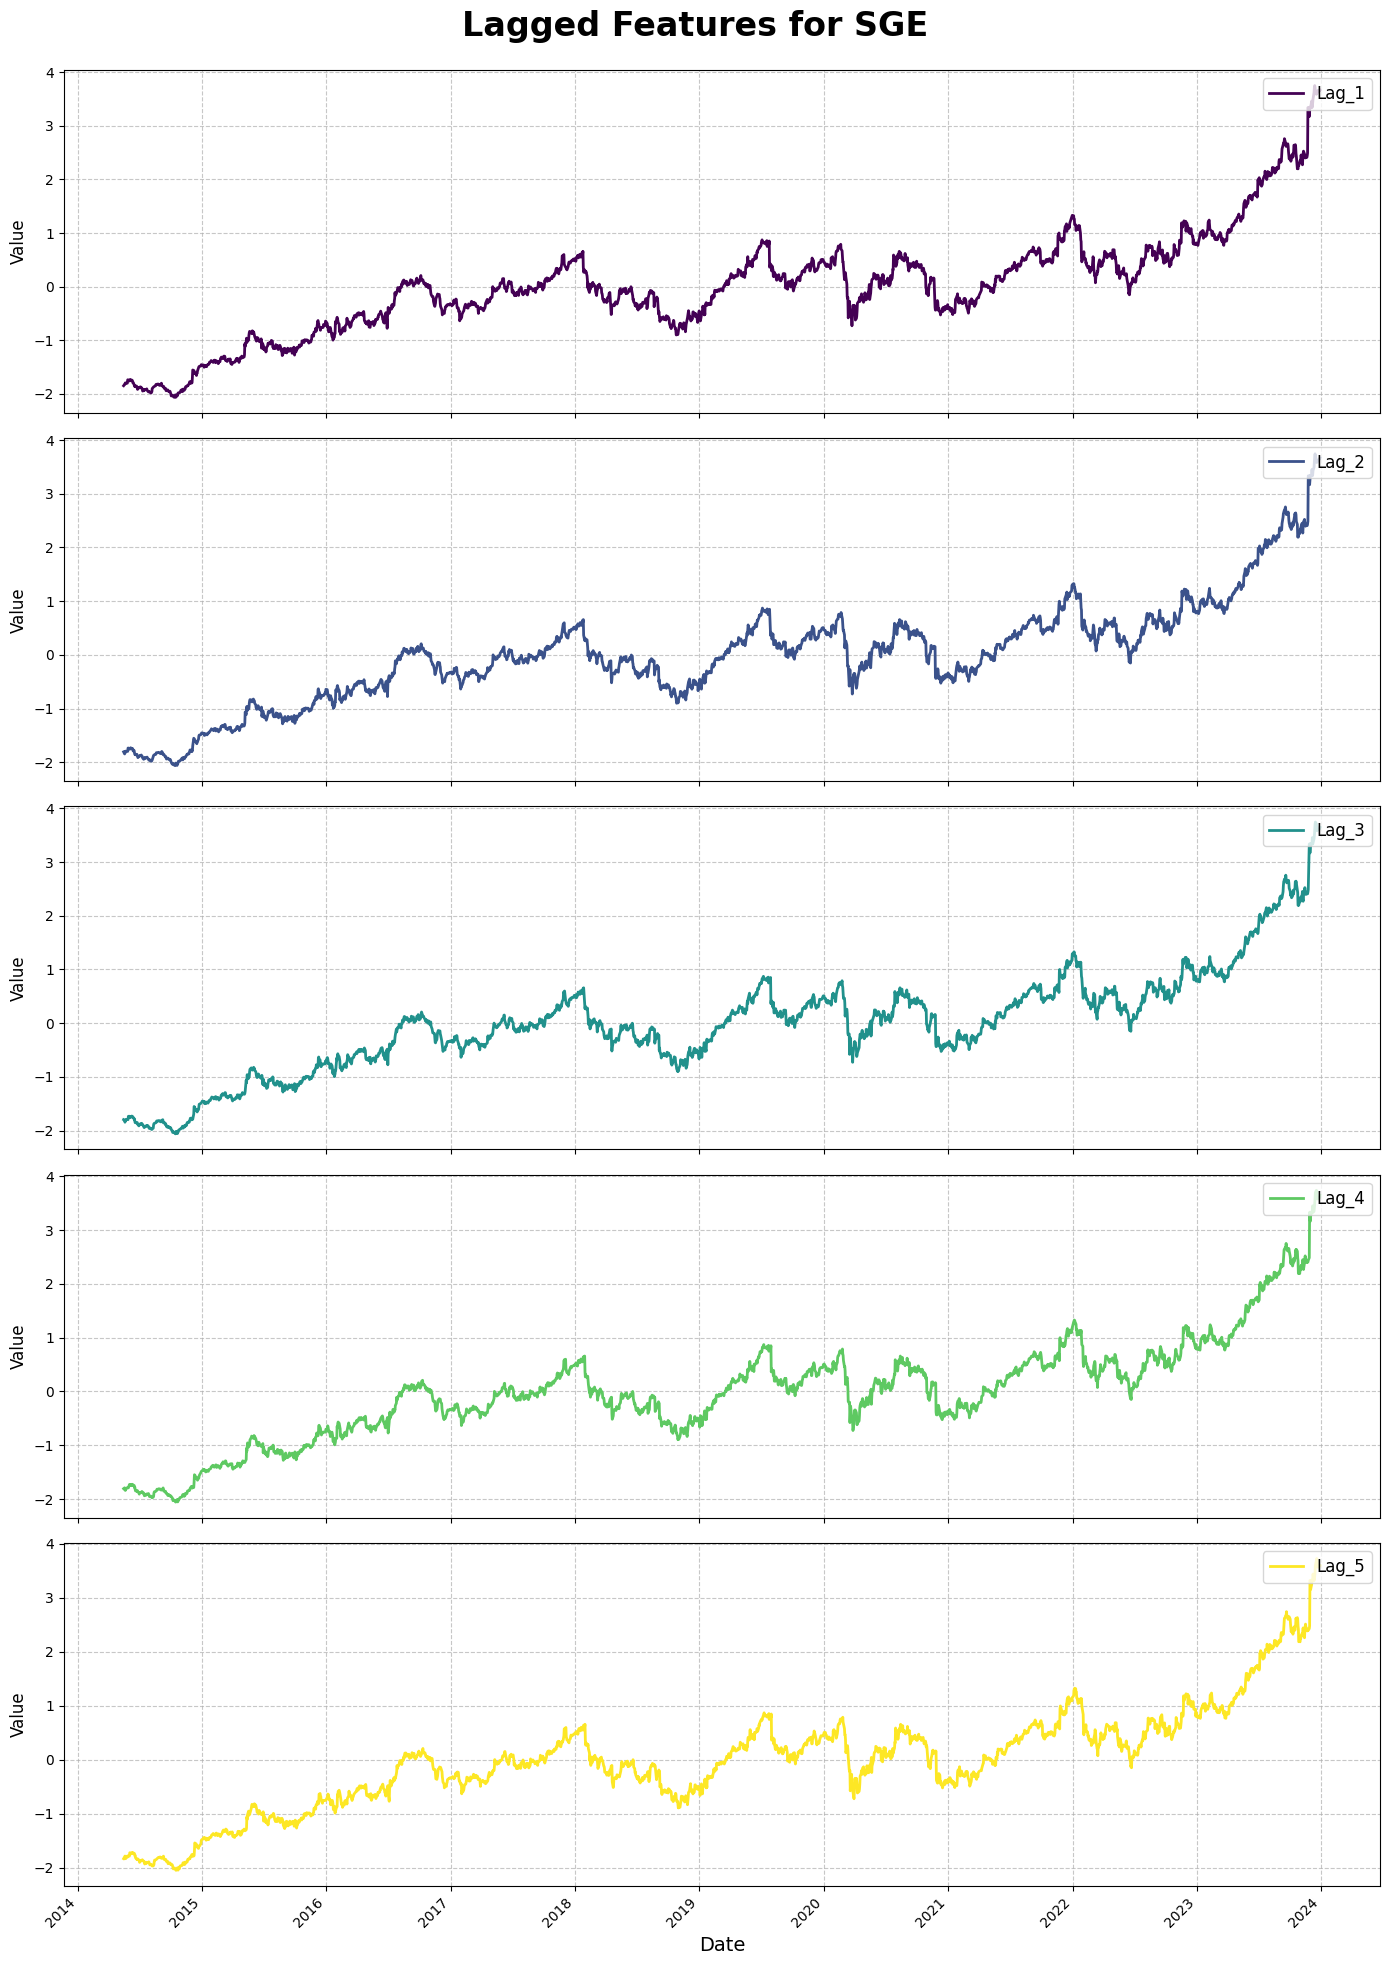

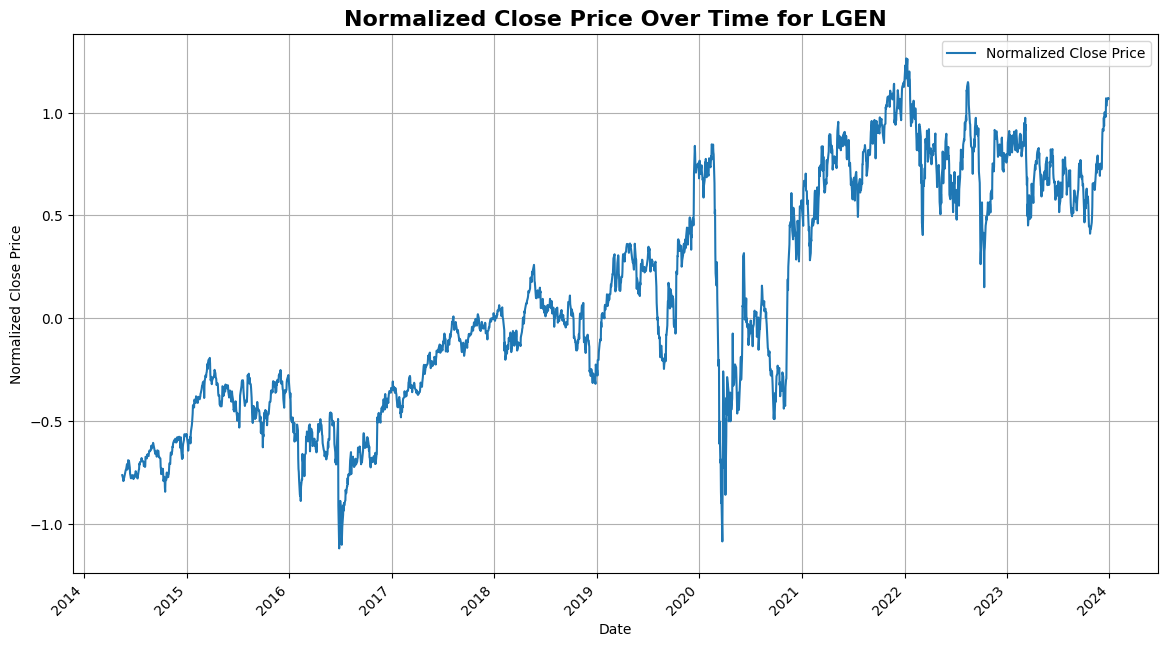

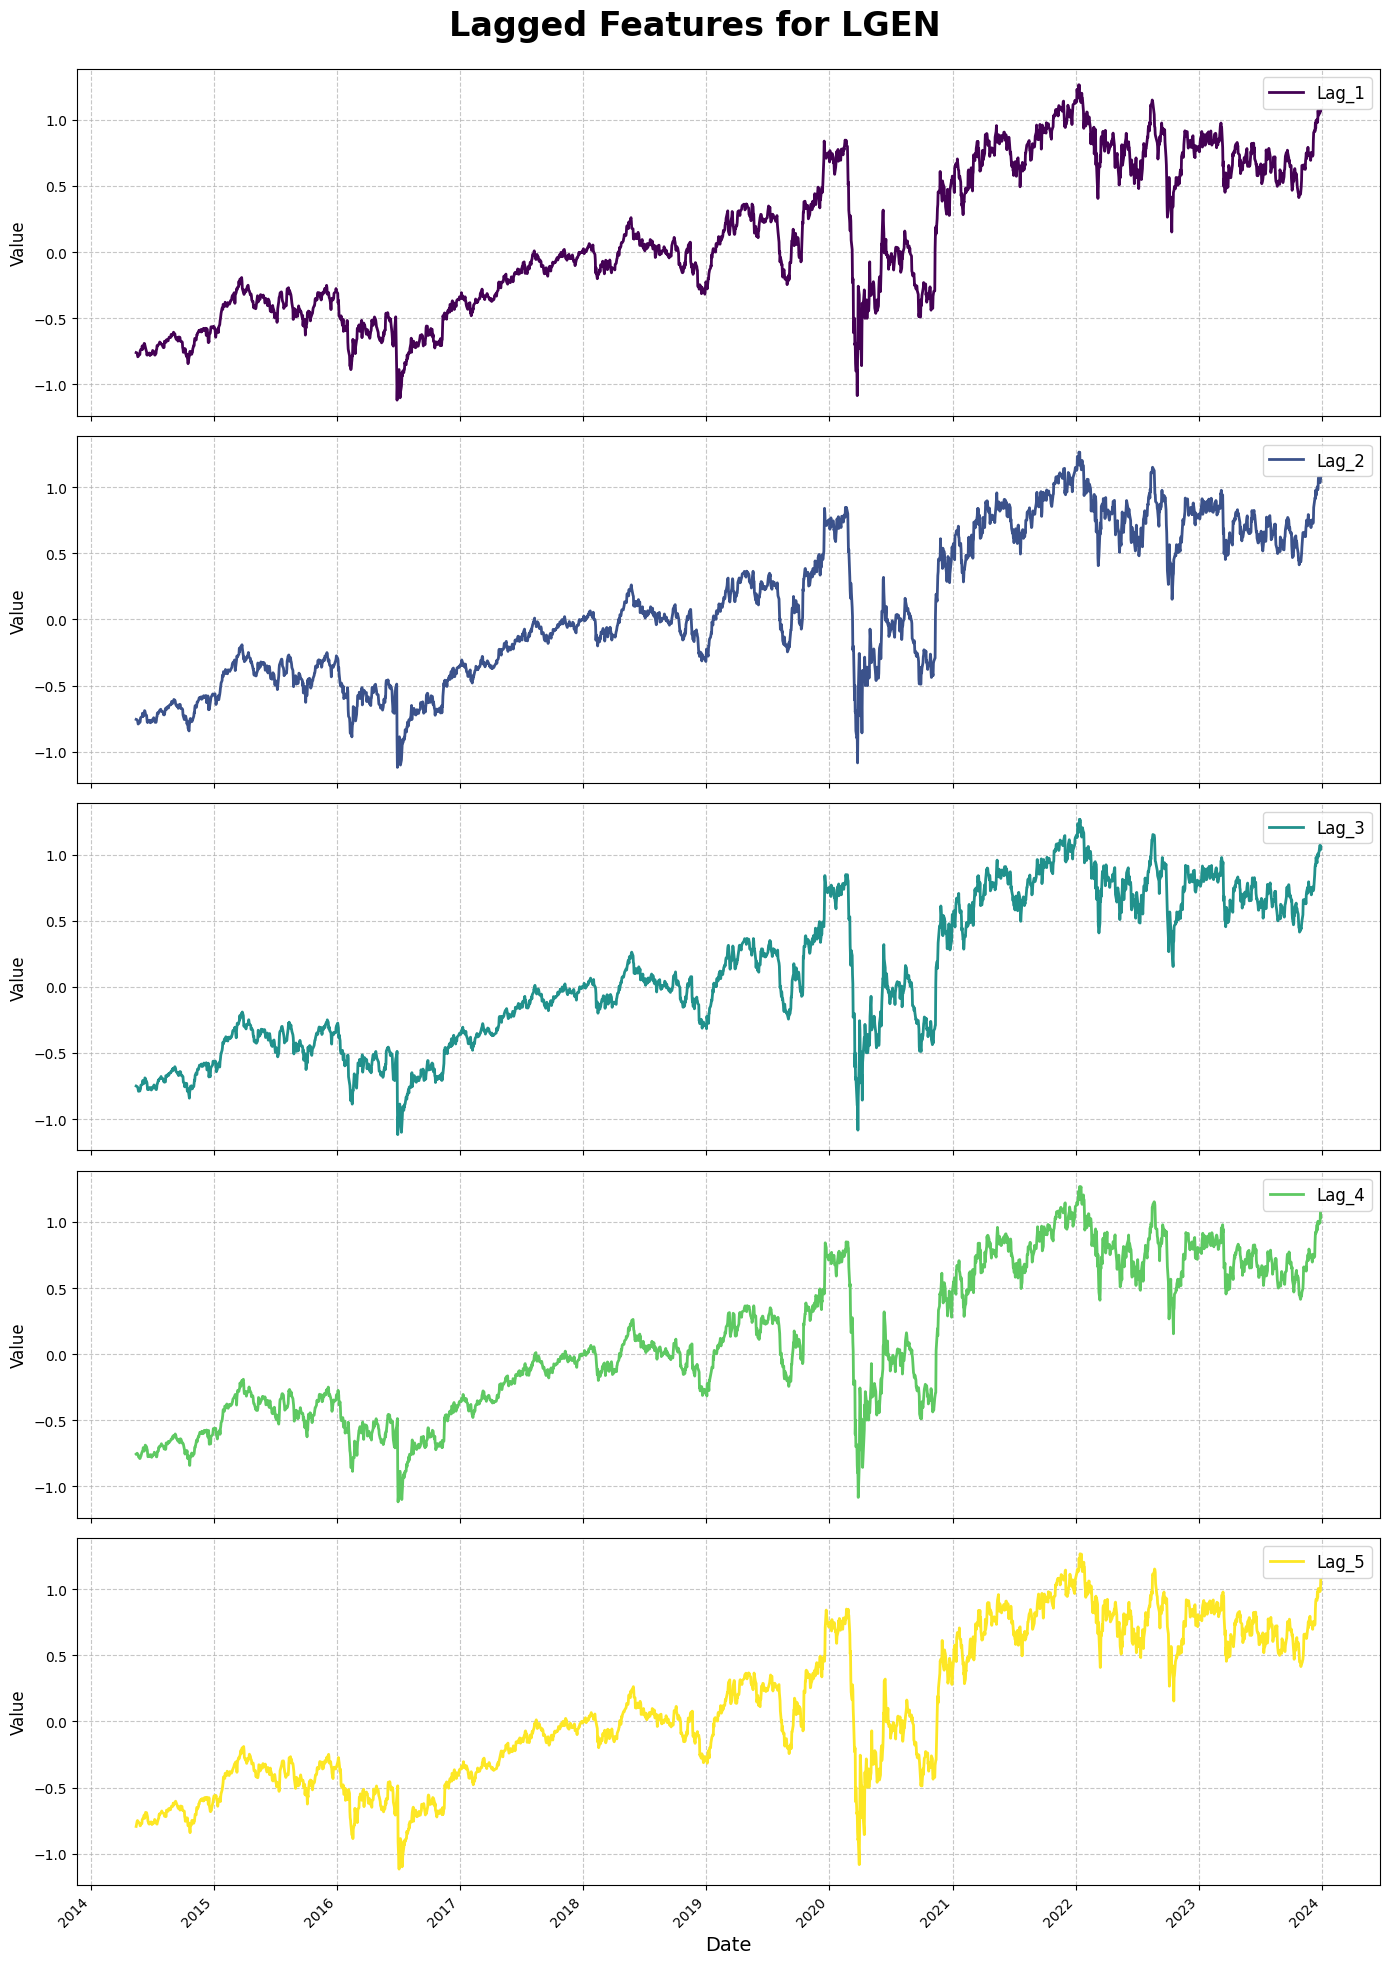

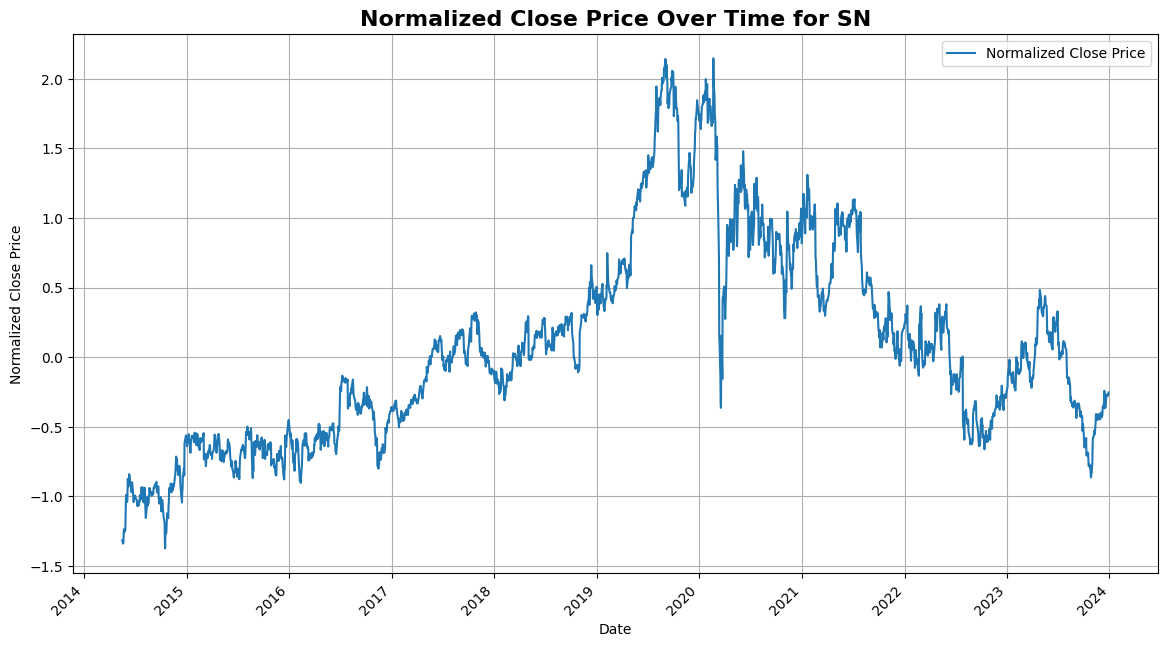

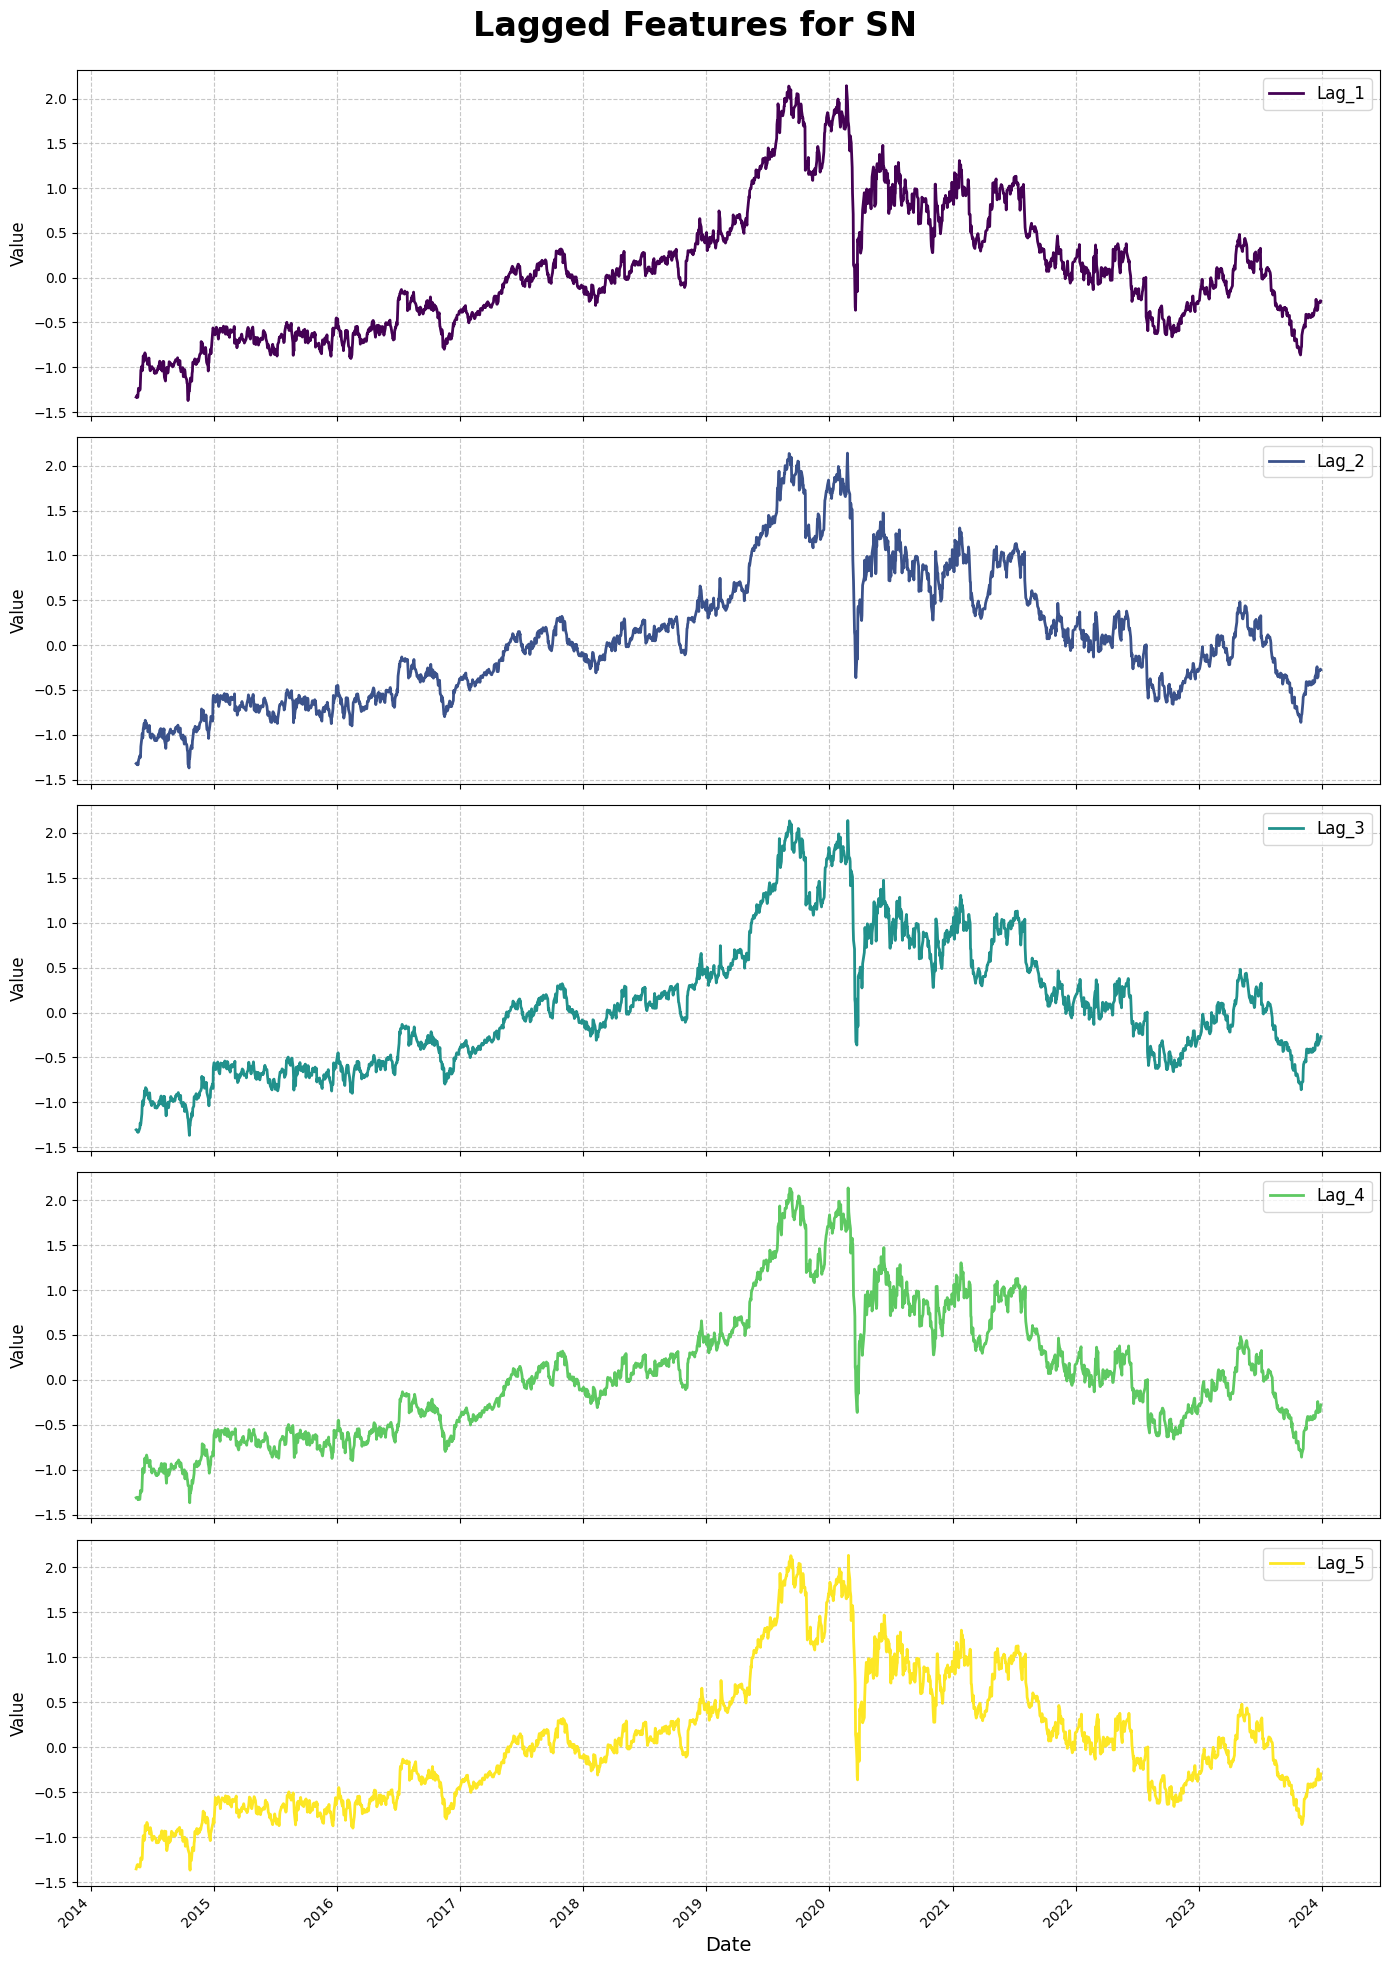

In [11]:
def preprocess_data(merged_df, window_size=60, max_lags=5):
    """
    Preprocess the data for LSTM model training.

    Parameters:
    - merged_df (pd.DataFrame): Merged DataFrame containing stock price data for multiple stocks.
    - window_size (int): Number of past time steps to use for LSTM input.
    - max_lags (int): Number of lagged features to visualize.

    Returns:
    - dict: Dictionary containing preprocessed data for each stock.
    """
    preprocessed_data = {}

    for column in merged_df.columns:
        if column != 'Date':
            df = merged_df[['Date', column]].copy()
            df.columns = ['Date', 'Close']

            # Normalize the data
            close_scaler = StandardScaler()
            df['Close_normalized'] = close_scaler.fit_transform(df[['Close']])

            # Add technical indicators
            df['SMA'] = df['Close_normalized'].rolling(window=20).mean()
            df['RSI'] = RSIIndicator(close=df['Close_normalized']).rsi()
            macd = MACD(close=df['Close_normalized'])
            df['MACD'] = macd.macd()
            df['MACD_Signal'] = macd.macd_signal()
            df['MACD_Diff'] = macd.macd_diff()
            bollinger = BollingerBands(close=df['Close_normalized'])
            df['BB_High'] = bollinger.bollinger_hband()
            df['BB_Low'] = bollinger.bollinger_lband()
            df.dropna(inplace=True)

            # Calculate returns
            df['Returns'] = df['Close'].pct_change()

            # Create lagged features
            for i in range(1, window_size + 1):
                df[f'Lag_{i}'] = df['Close_normalized'].shift(i)
            df.dropna(inplace=True)

            # Handle outliers using robust scaling
            features = ['Close_normalized', 'SMA', 'RSI', 'MACD',
                        'MACD_Signal', 'MACD_Diff', 'BB_High',
                        'BB_Low'] + [f'Lag_{i}' for i in range(1,
                                                               window_size + 1)]
            robust_scaler = RobustScaler()
            df[features] = robust_scaler.fit_transform(df[features])

            # Prepare features and target
            features = ['Returns'] + [f'Lag_{i}' for i in range(1, window_size + 1)]

            X = df[features].values
            y = df['Close_normalized'].values

            preprocessed_data[column] = {
                'X': X,
                'y': y,
                'scaler': robust_scaler,
                'df': df
            }

            # Visualization of normalized close prices
            plt.figure(figsize=(14, 7))
            plt.plot(df['Date'], df['Close_normalized'], label='Normalized Close Price')
            plt.title(f'Normalized Close Price Over Time for {column}',
                      fontweight='bold', fontsize=16)
            plt.xlabel('Date')
            plt.ylabel('Normalized Close Price')
            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45, ha='right')
            plt.show()

            # Visualization of lagged features
            fig, axs = plt.subplots(max_lags, 1, figsize=(14, 20), sharex=True)
            fig.suptitle(f'Lagged Features for {column}', fontsize=24, fontweight='bold')

            colors = plt.cm.viridis(np.linspace(0, 1, max_lags))
            lags = [f'Lag_{i}' for i in range(1, max_lags + 1)]

            for i, lag in enumerate(lags):
                axs[i].plot(df['Date'], df[lag], color=colors[i], linewidth=2, label=lag)
                axs[i].set_ylabel('Value', fontsize=12)
                axs[i].legend(loc='upper right', fontsize=12)
                axs[i].grid(True, linestyle='--', alpha=0.7)
                axs[i].tick_params(axis='both', which='major', labelsize=10)

            axs[-1].set_xlabel('Date', fontsize=14)
            plt.setp(axs[-1].get_xticklabels(), rotation=45, ha='right')

            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.subplots_adjust(top=0.95)  # Adjust to make room for suptitle
            plt.show()

    return preprocessed_data


# Set random seeds for reproducibility
set_random_seeds()

# Preprocess the data
preprocessed_data = preprocess_data(merged_df)

## Build LSTM Model with Attention Mechanism

The following function
would build  an LSTM model
with an attention mechanism that
 would help  capture important
patterns in the data.

Random seeds set to 42 for reproducibility.


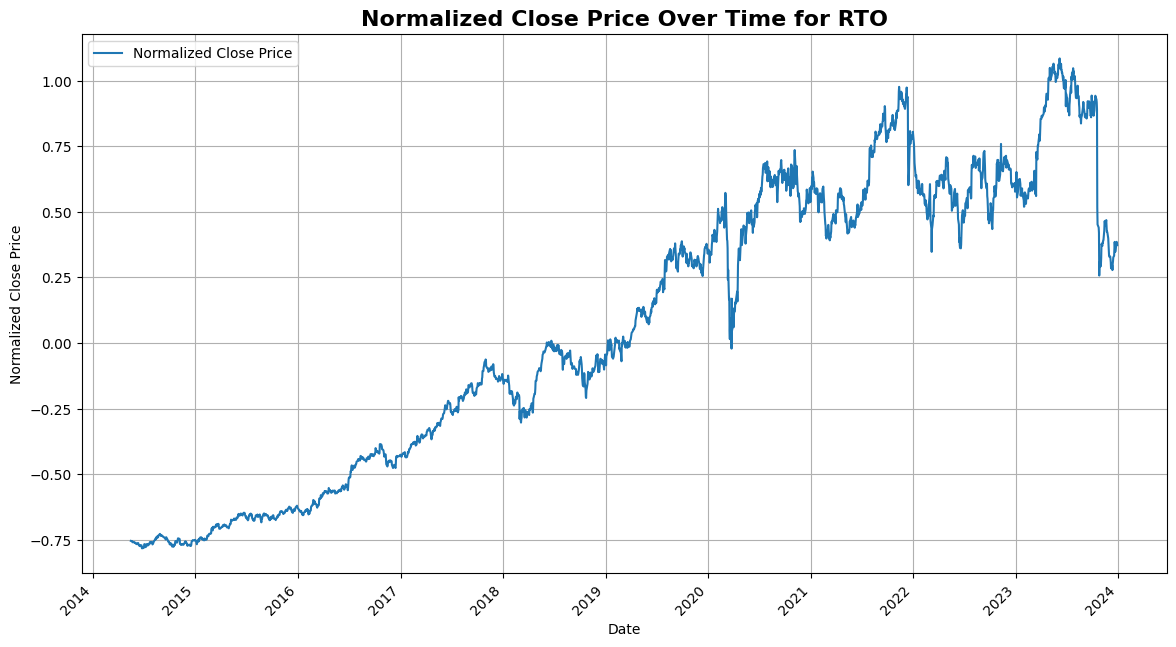

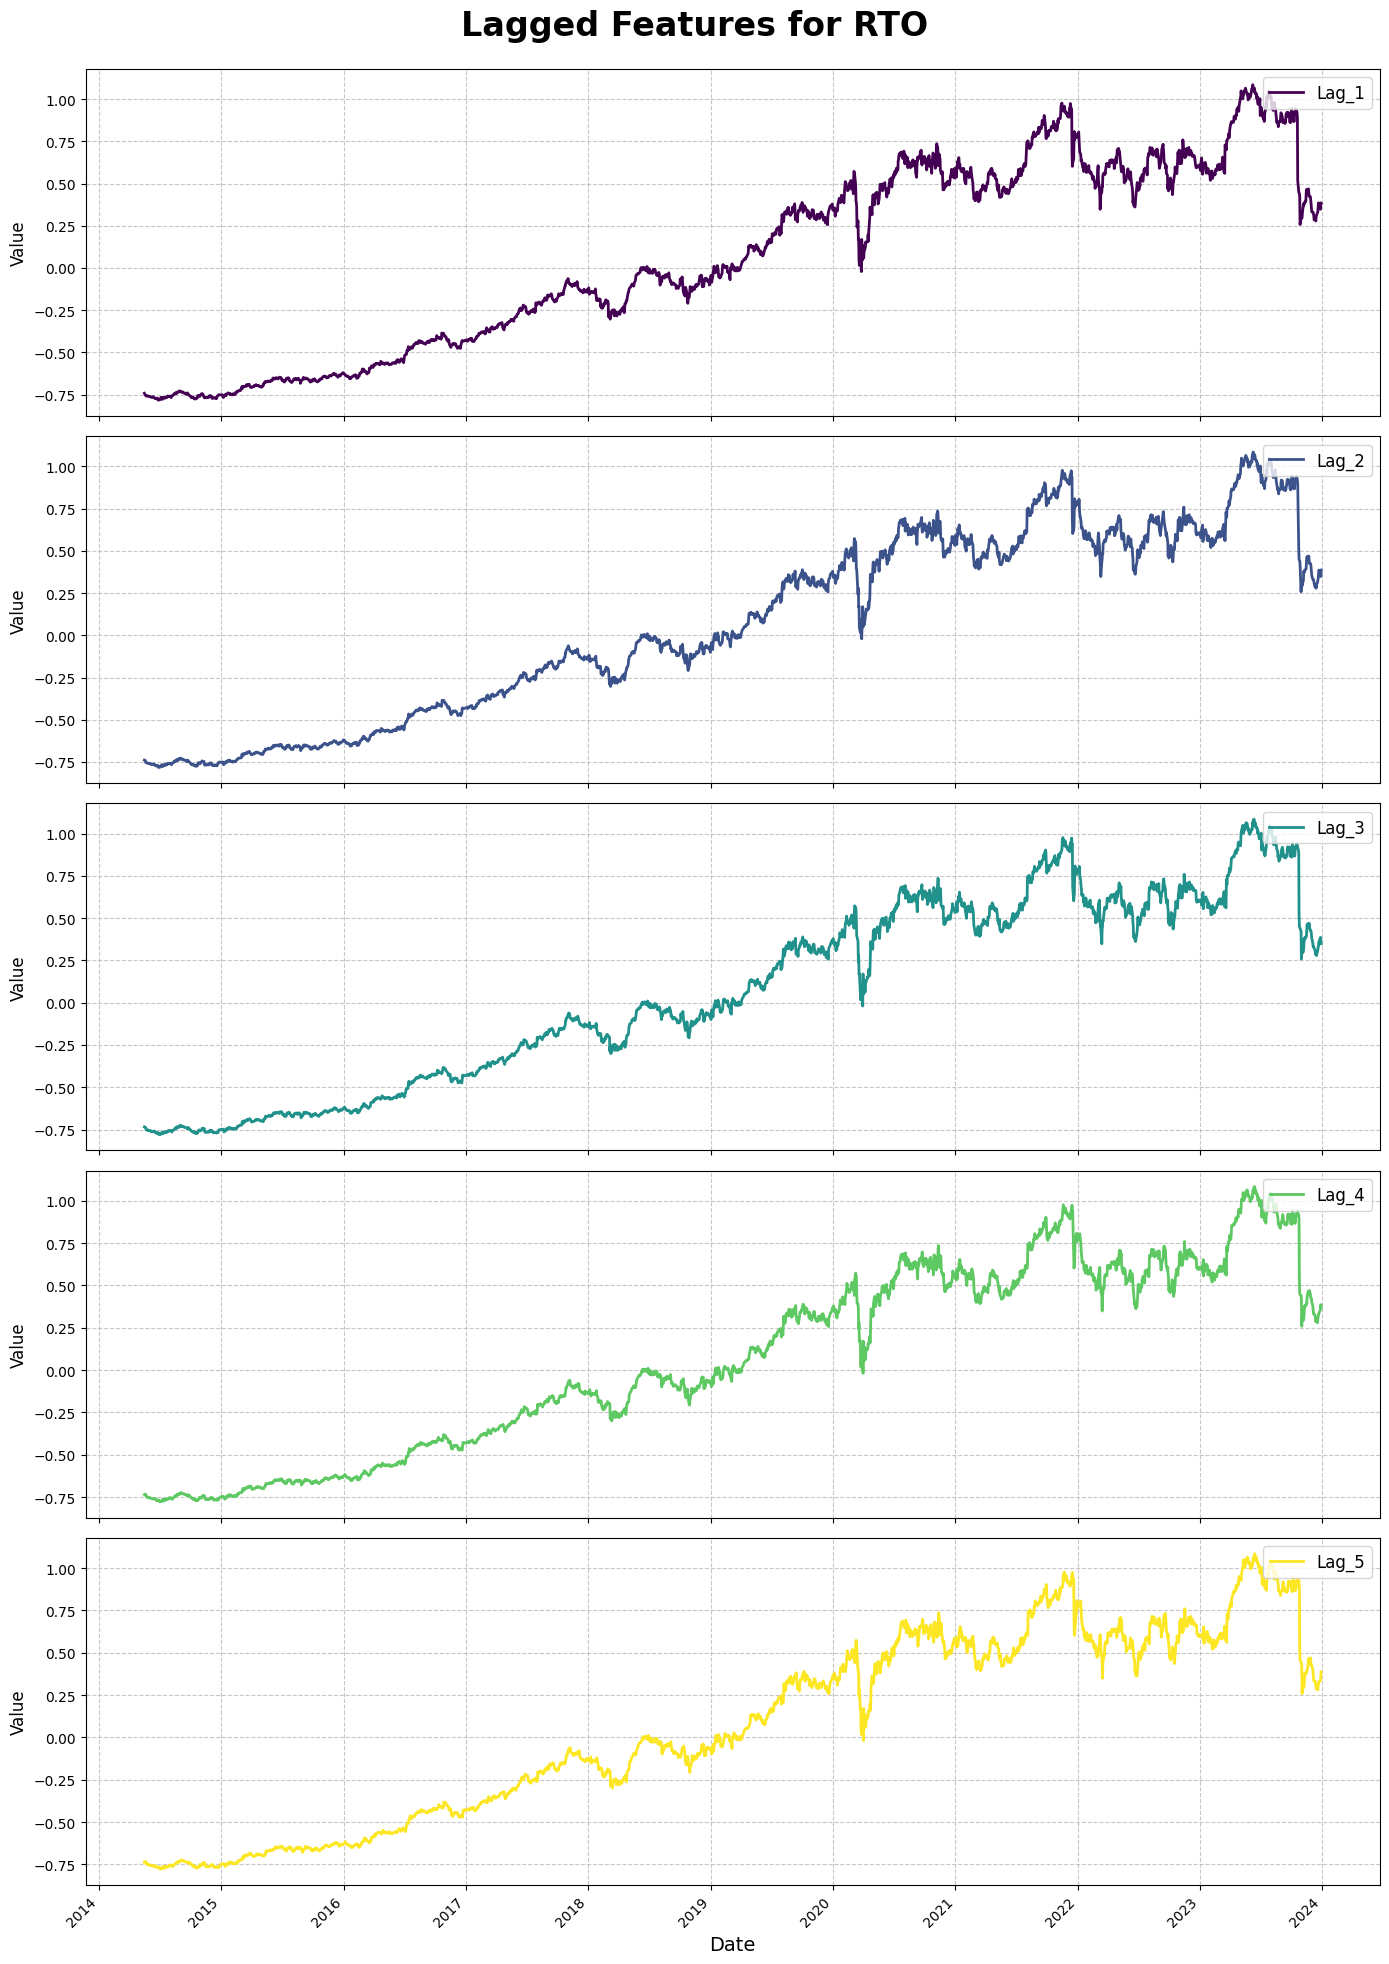

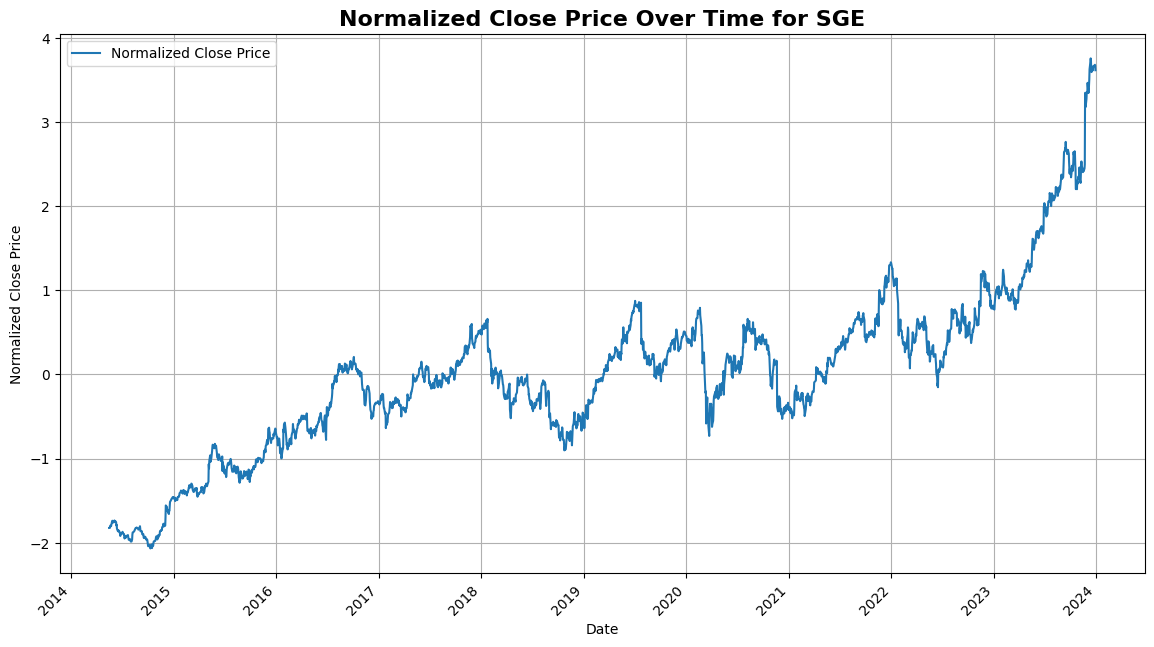

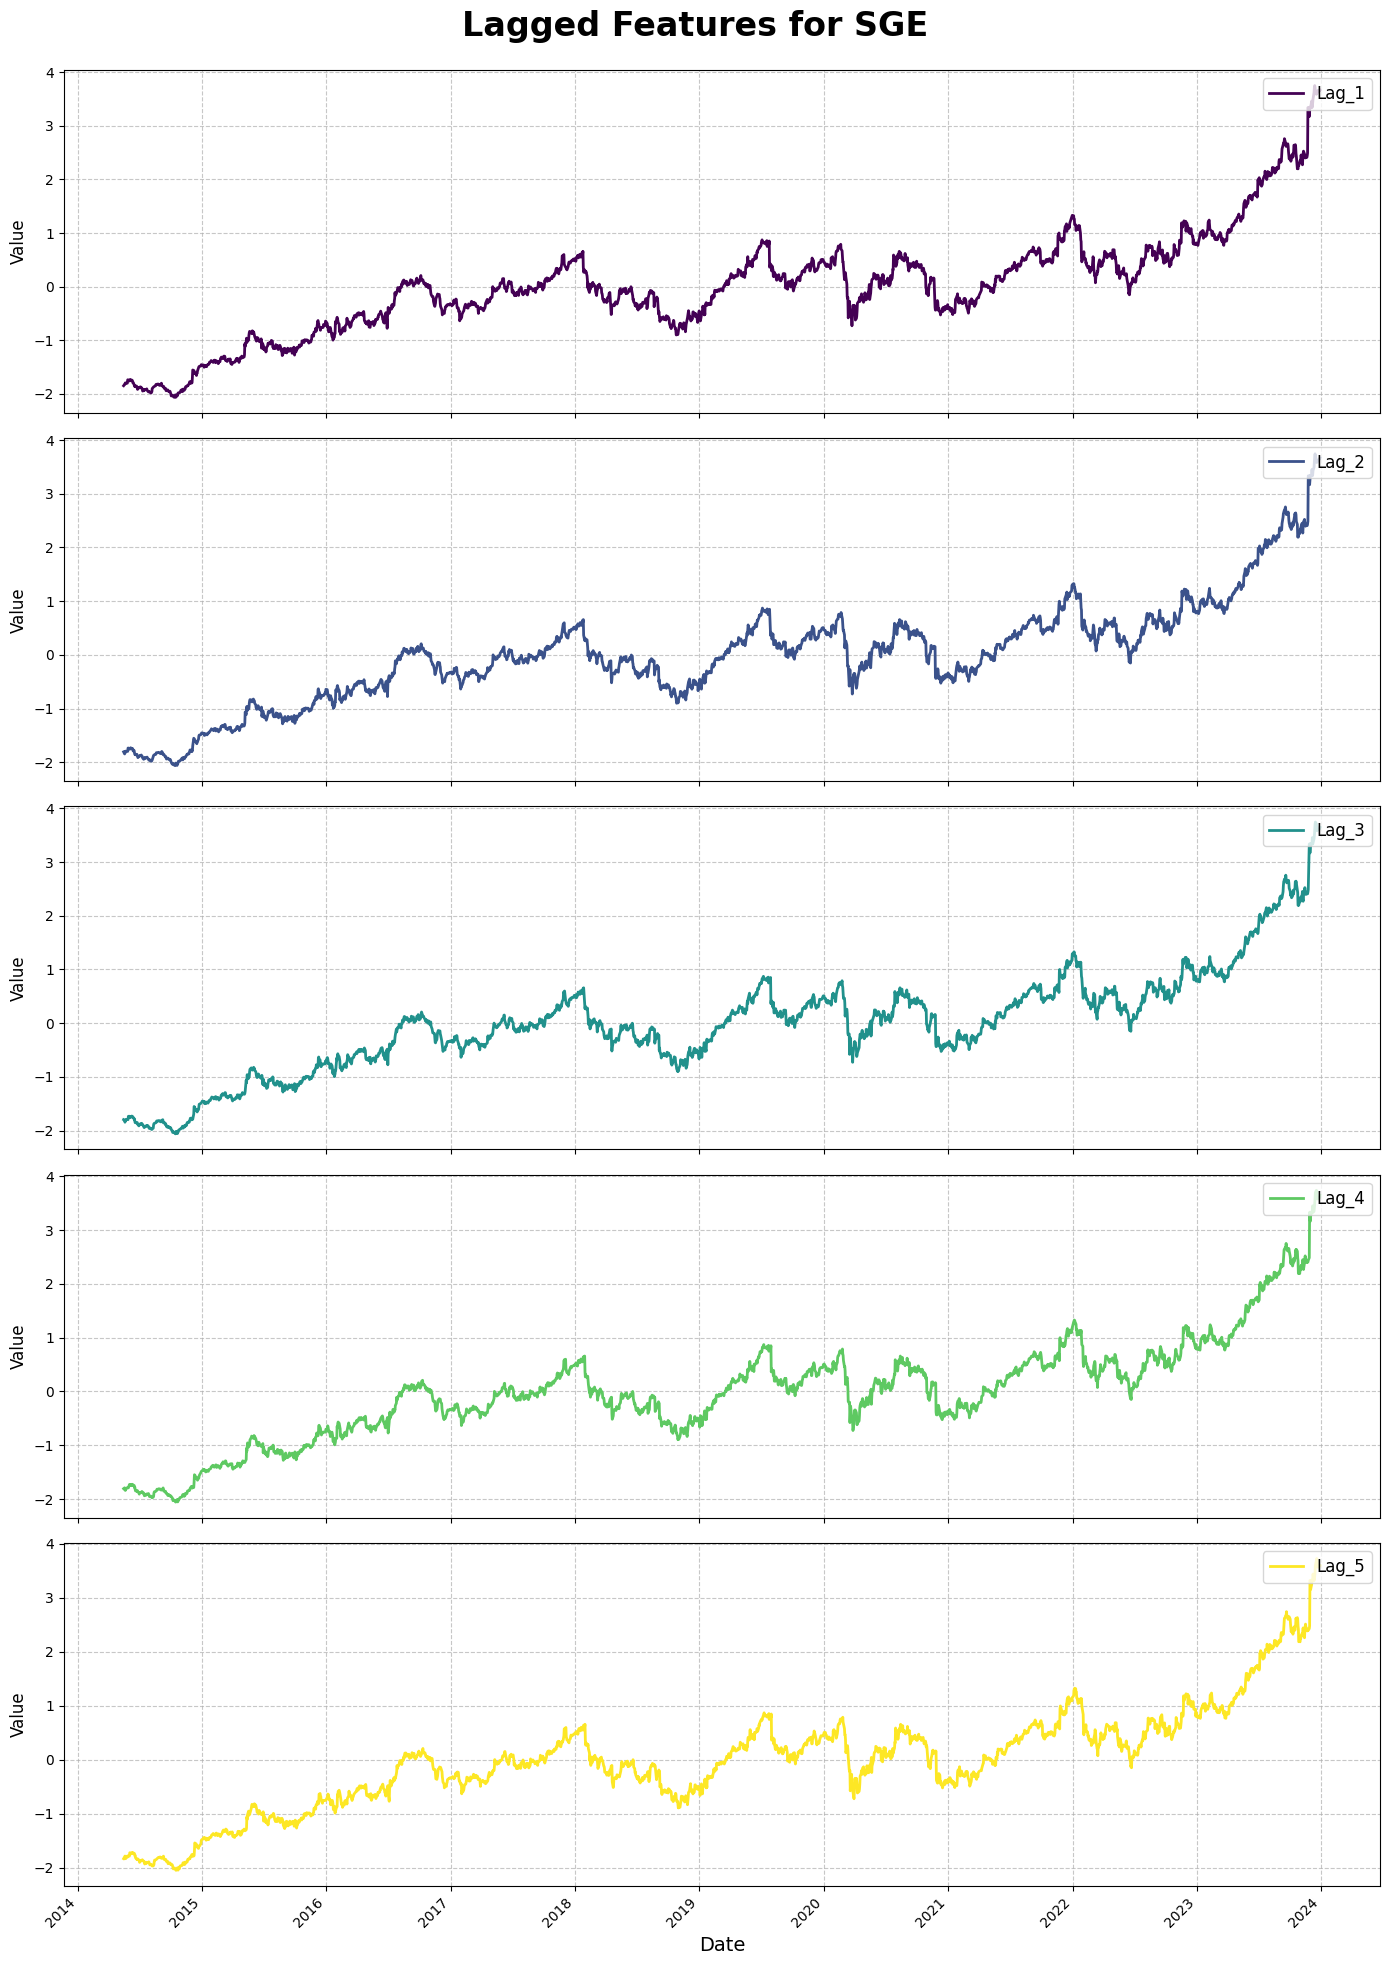

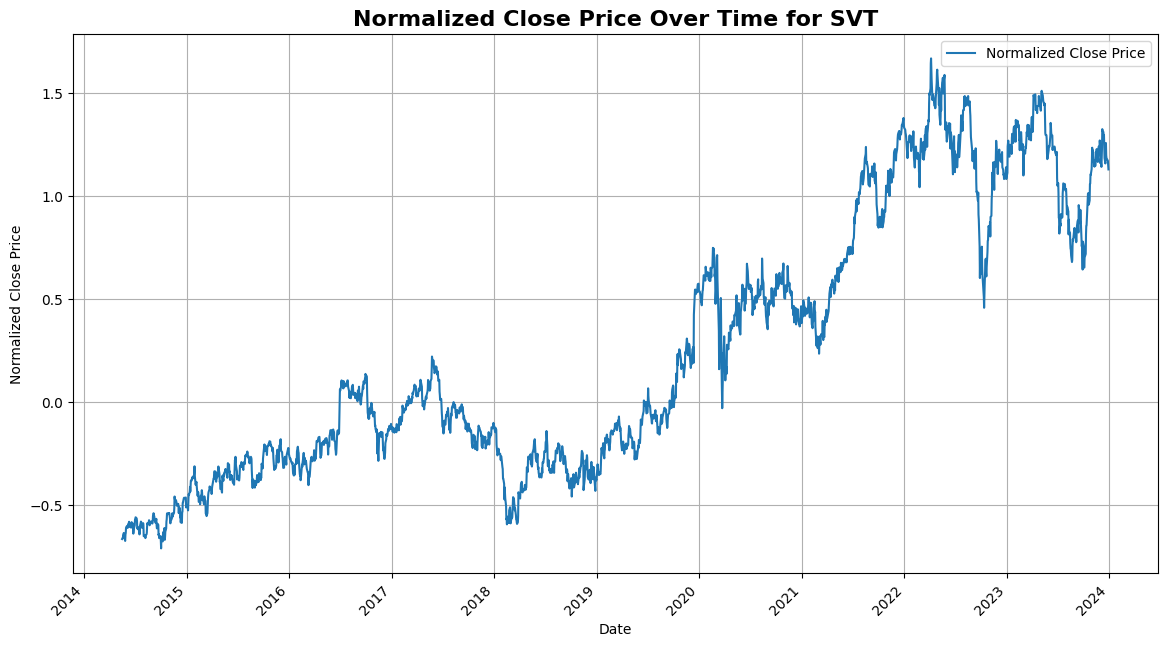

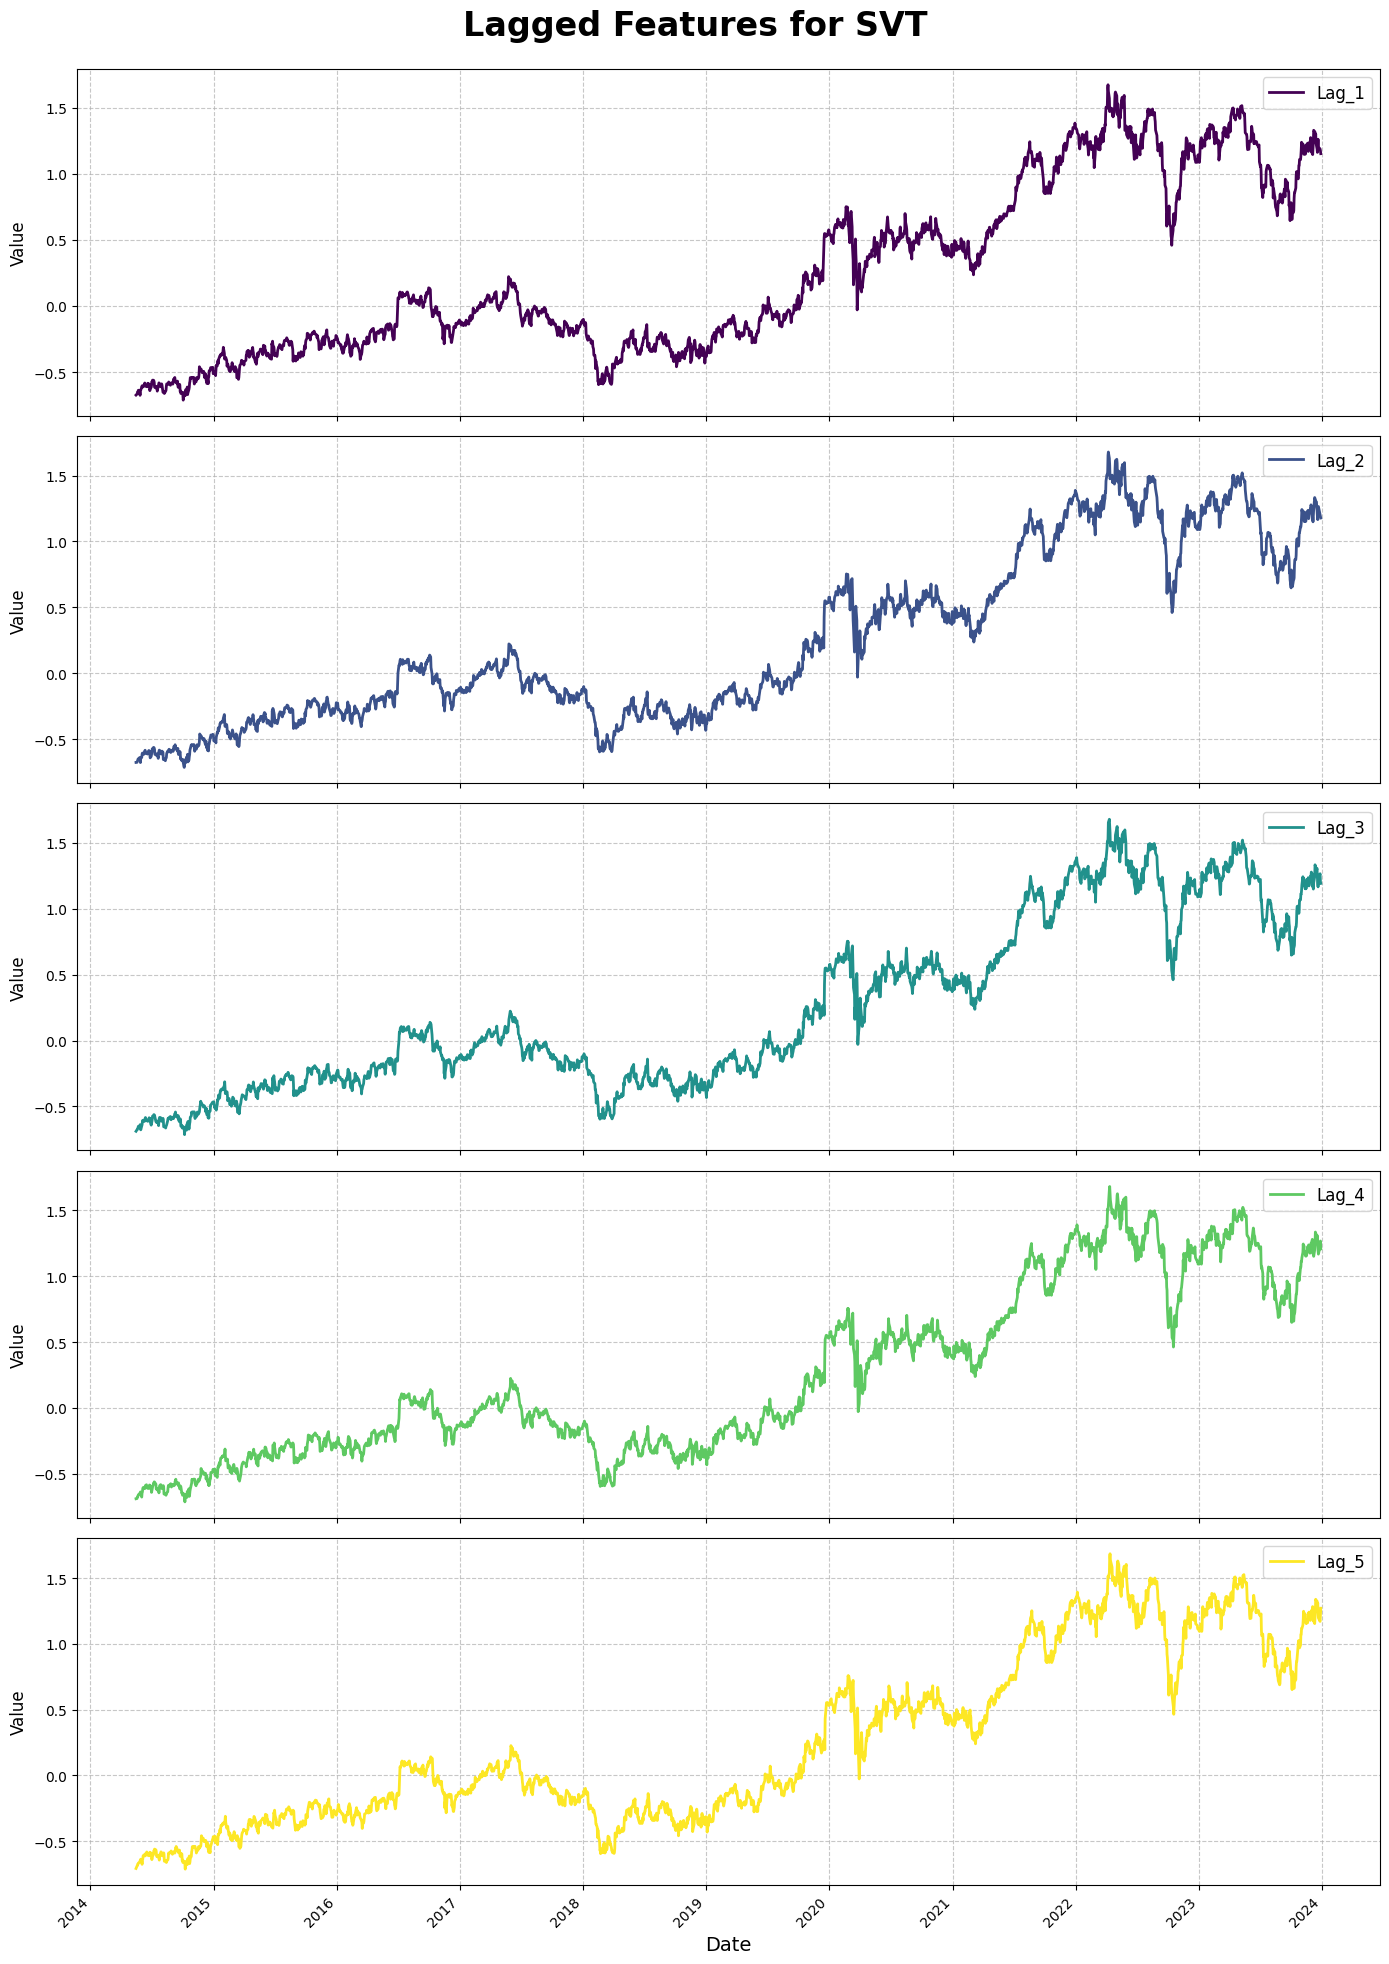

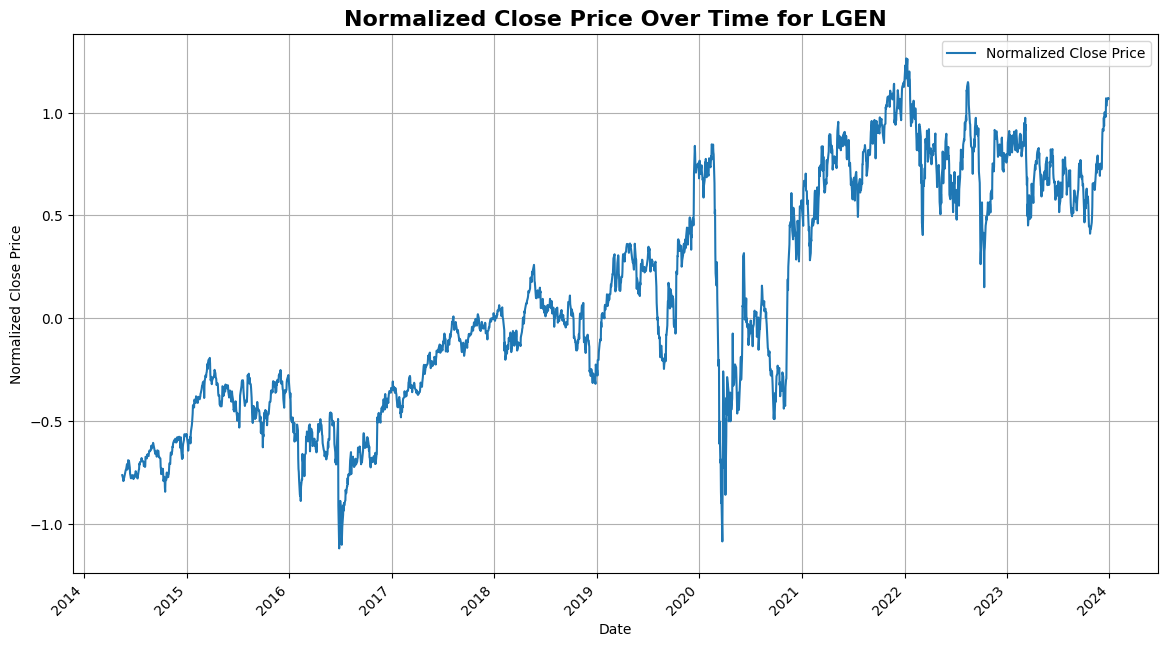

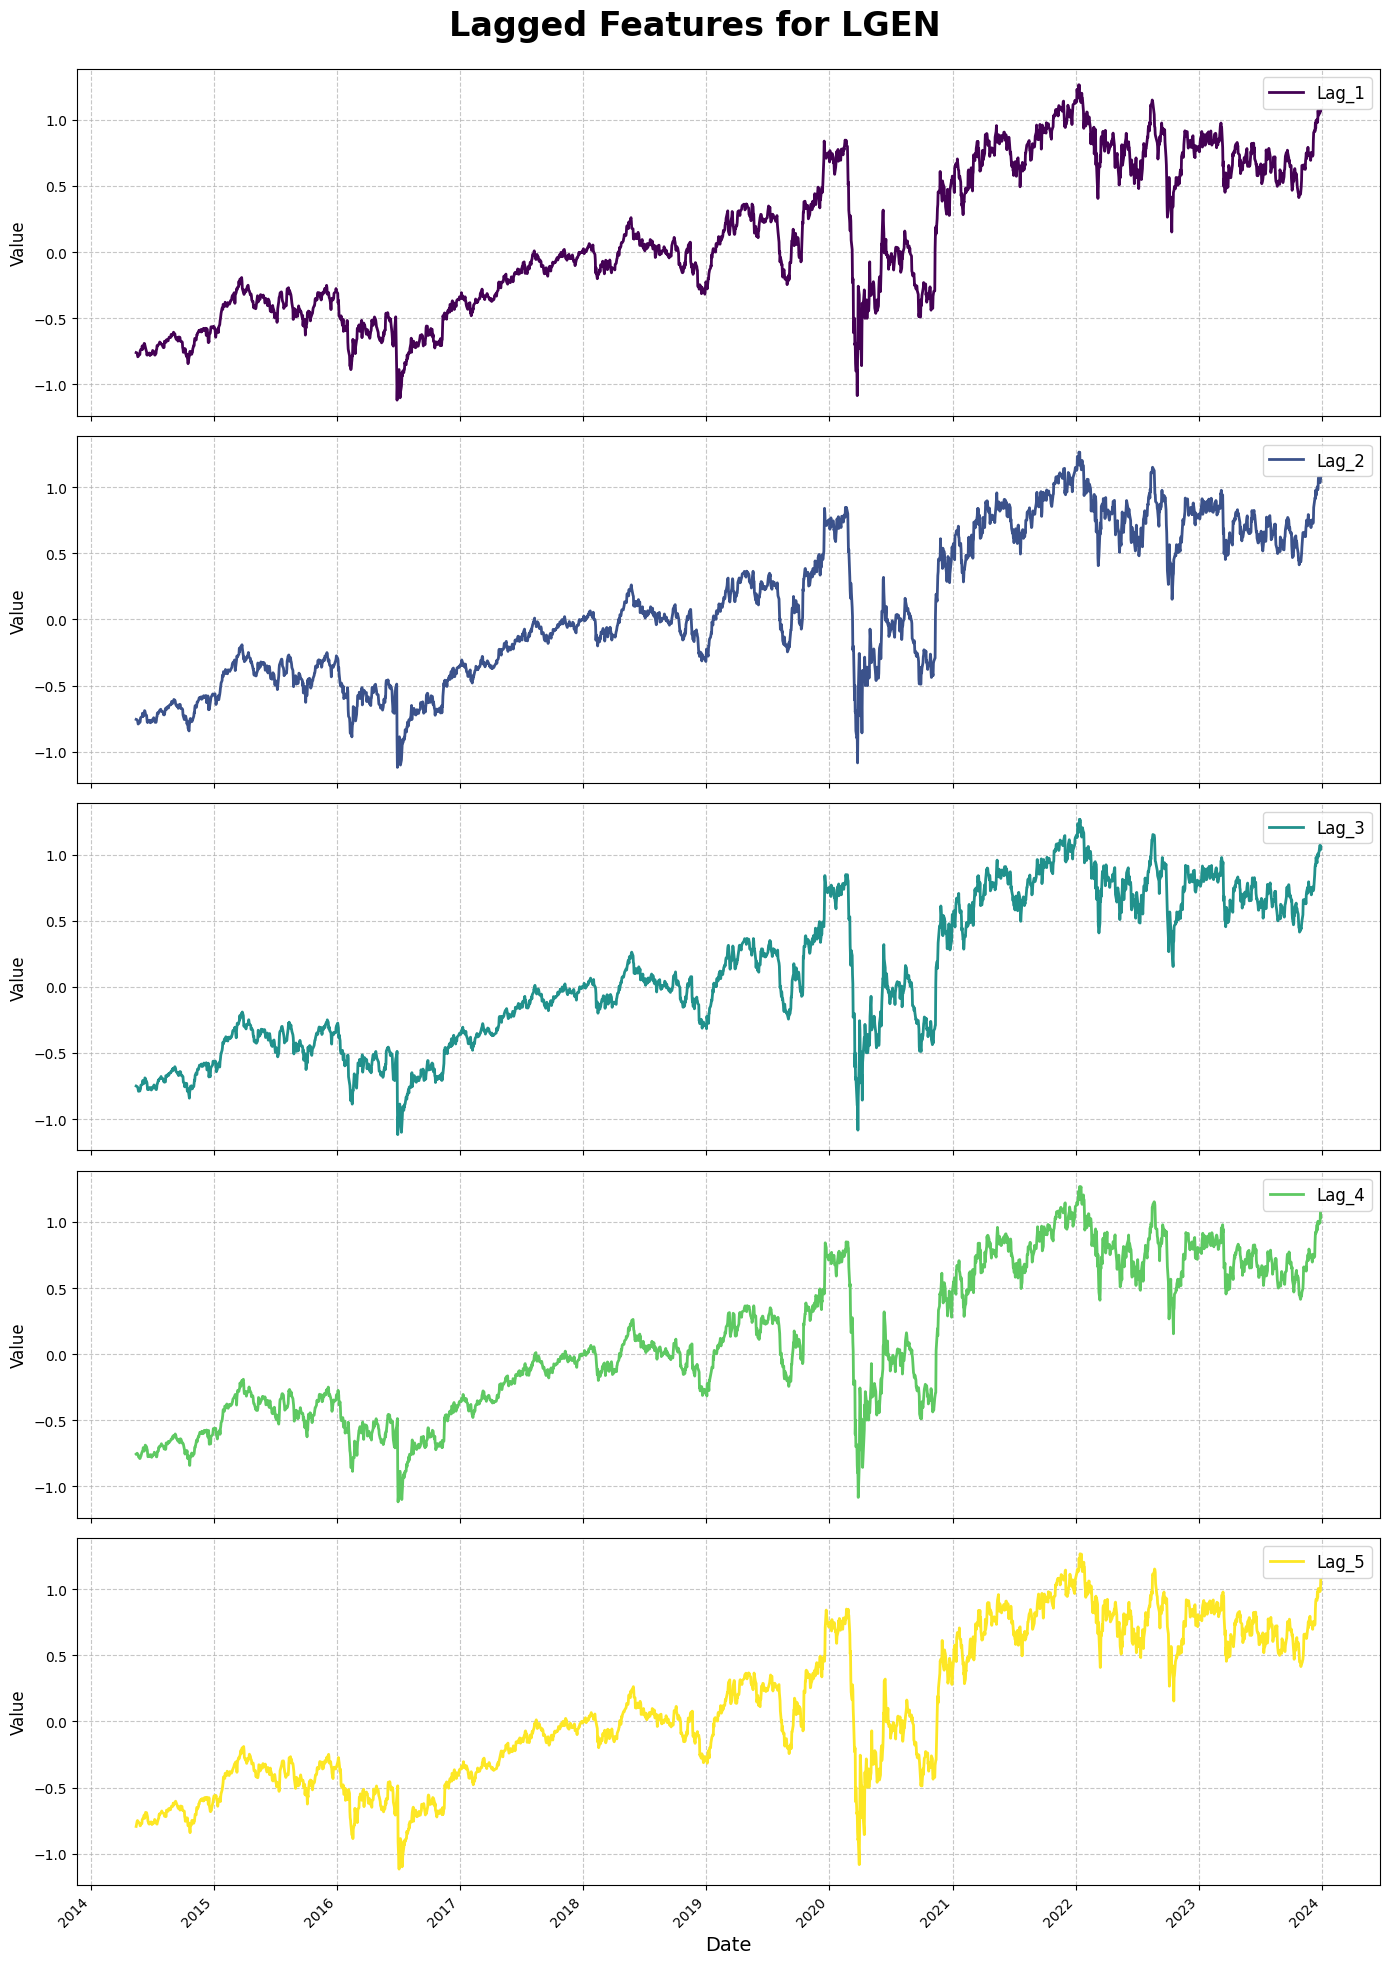

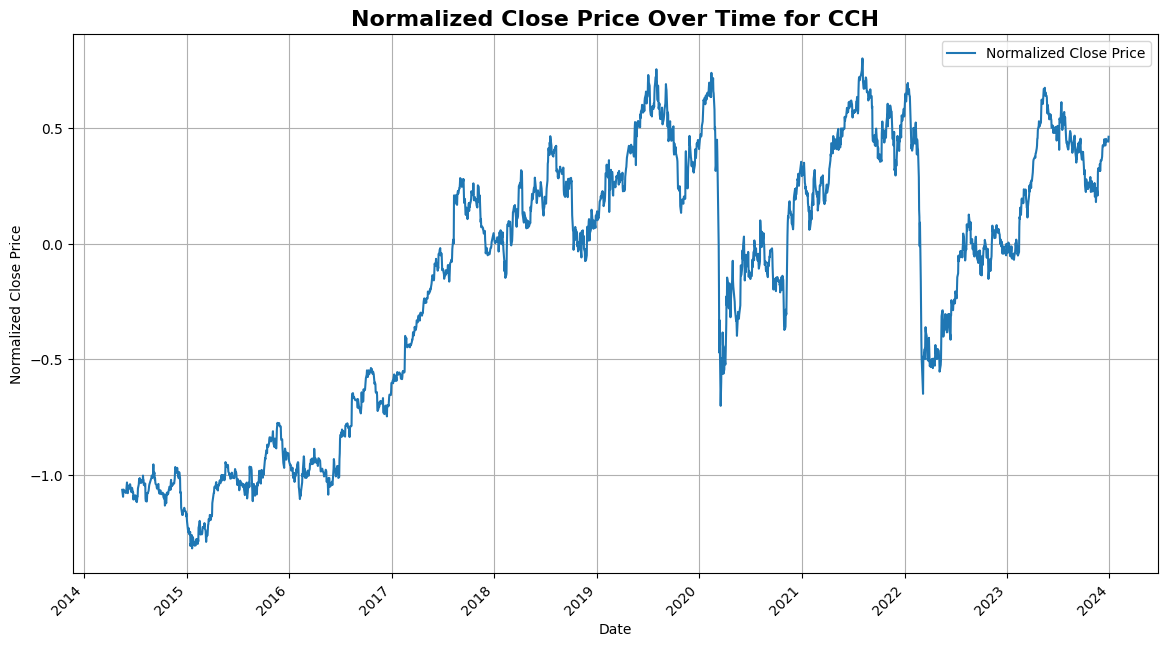

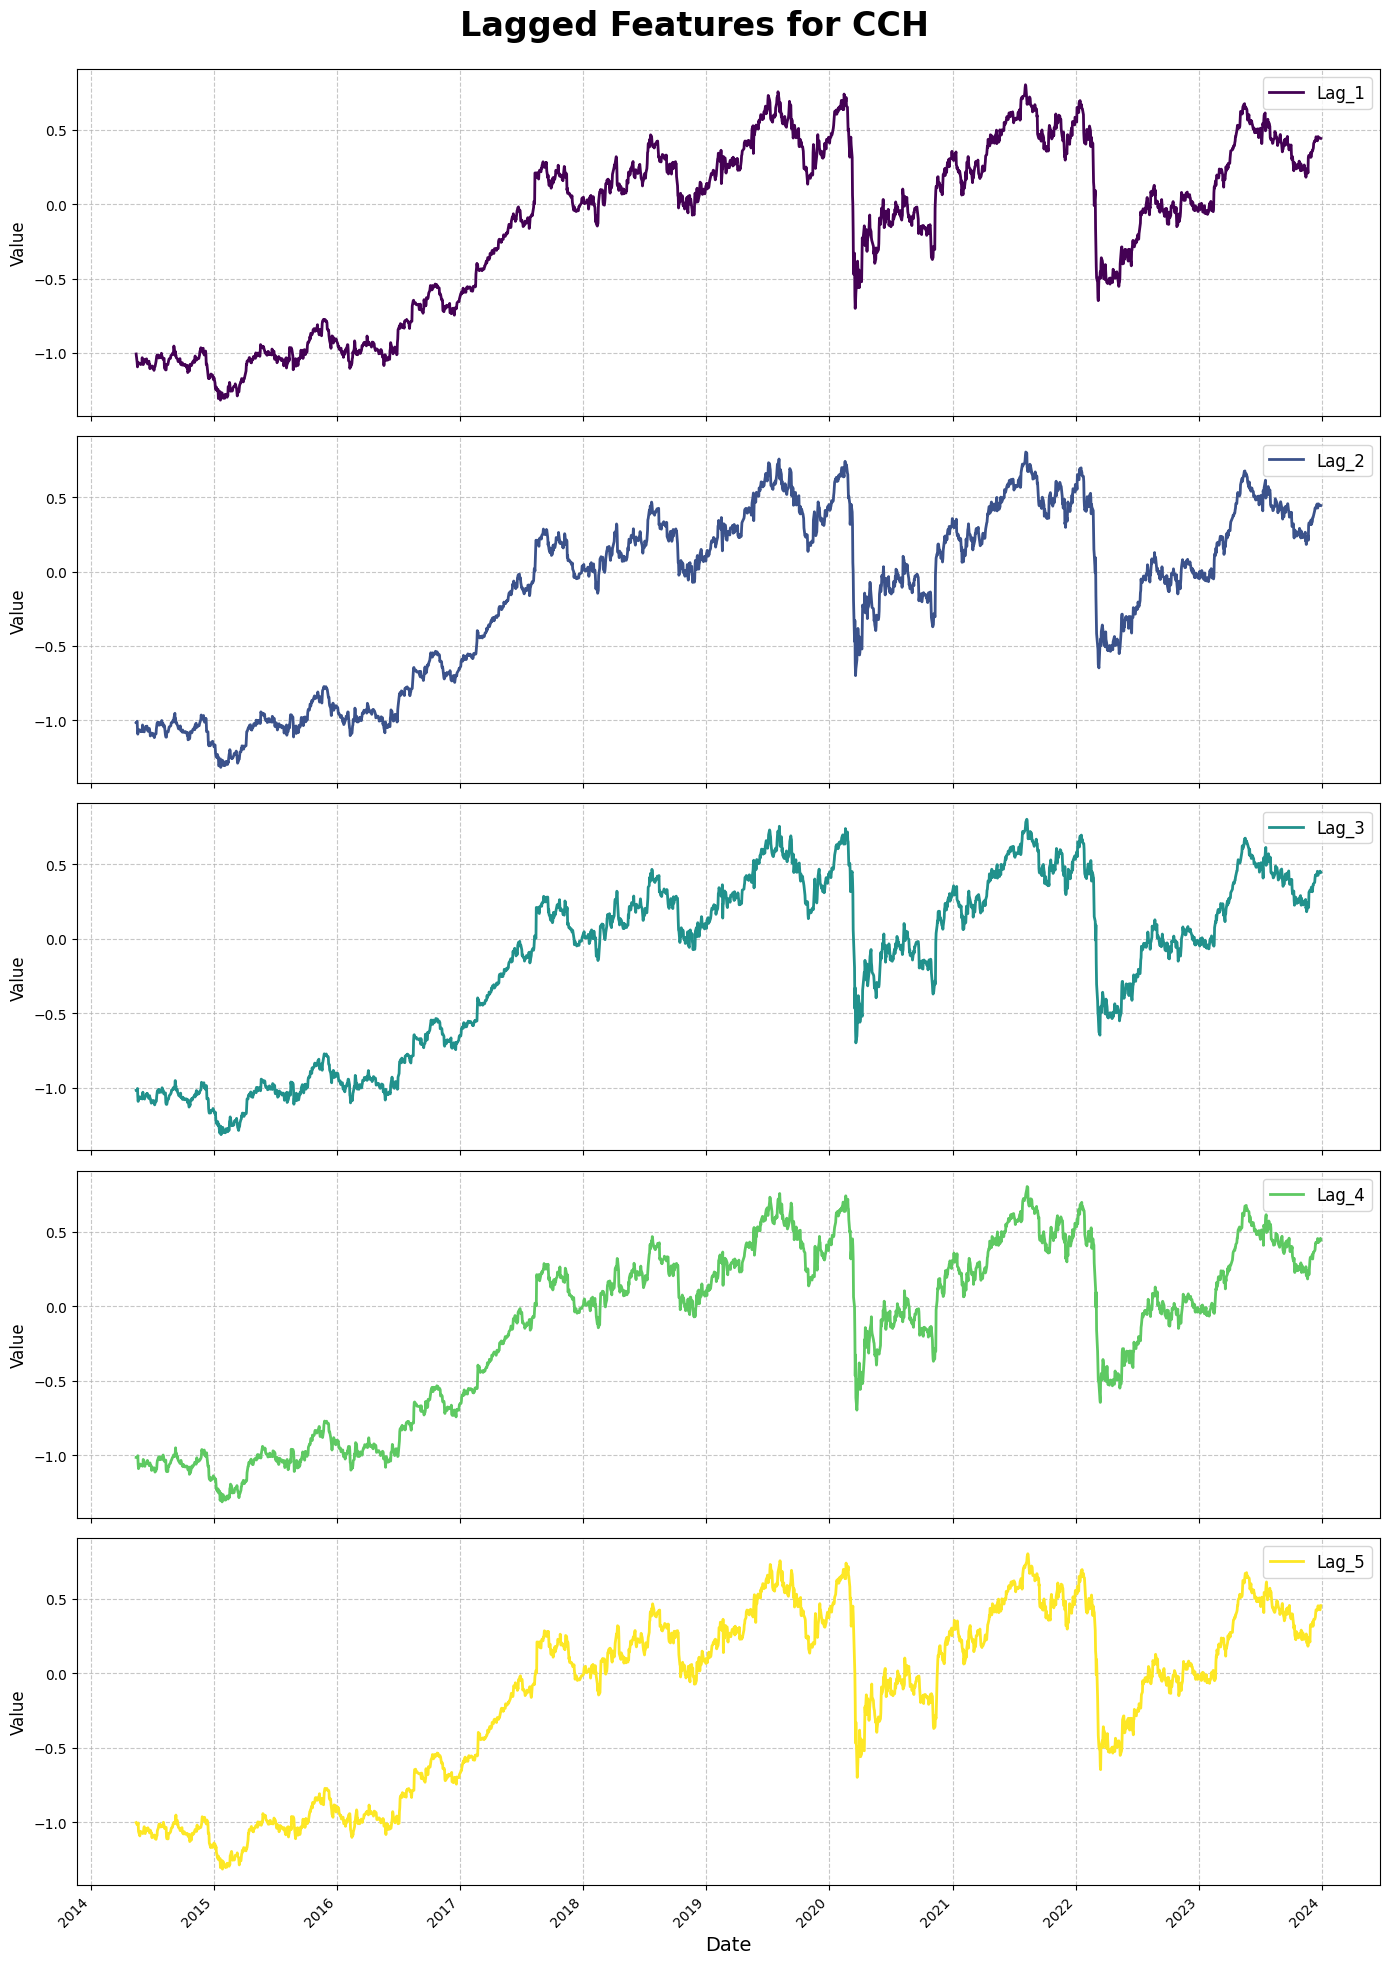

Epoch 1/100
31/31 [==============================] - 31s 889ms/step - loss: 0.1285 - mae: 0.4288 - val_loss: 0.2456 - val_mae: 0.6712
Epoch 2/100
31/31 [==============================] - 25s 808ms/step - loss: 0.1291 - mae: 0.4433 - val_loss: 0.2456 - val_mae: 0.6712
Epoch 3/100
31/31 [==============================] - 28s 909ms/step - loss: 0.1291 - mae: 0.4433 - val_loss: 0.2456 - val_mae: 0.6712
Epoch 4/100
31/31 [==============================] - 27s 878ms/step - loss: 0.1291 - mae: 0.4433 - val_loss: 0.2456 - val_mae: 0.6712
Epoch 5/100
31/31 [==============================] - 25s 816ms/step - loss: 0.1291 - mae: 0.4433 - val_loss: 0.2456 - val_mae: 0.6712
Epoch 6/100
28/31 [==========================>...] - ETA: 2s - loss: 0.1302 - mae: 0.4453

In [ ]:
def build_and_train_model(preprocessed_data, epochs=100, batch_size=64, window_size=60):
    """
    Build and train an LSTM model with attention mechanism for multiple stocks.

    Parameters:
    - preprocessed_data (dict): Dictionary containing preprocessed data for each stock.
    - epochs (int): Number of epochs for training the model.
    - batch_size (int): Batch size for training the model.
    - window_size (int): Number of past time steps to use for LSTM input.

    Returns:
    - dict: Dictionary containing trained models for each stock.
    """
    models = {}

    for stock, data in preprocessed_data.items():
        X, y = data['X'], data['y']
        # Reshape data for LSTM (samples, timesteps, features)
        X = X.reshape((X.shape[0], window_size + 1, -1))

        # Build LSTM model with attention
        model_input = Input(shape=(X.shape[1], X.shape[2]))
        lstm_out = LSTM(256, return_sequences=True)(model_input)
        attention_out = Attention()([lstm_out, lstm_out])
        lstm_out = LSTM(256)(attention_out)
        dropout_out = Dropout(0.3)(lstm_out)
        model_output = Dense(1, activation='sigmoid')(dropout_out)
        model = Model(inputs=model_input, outputs=model_output)

        model.compile(optimizer=Adam(), loss='huber_loss', metrics=['mae'])
        model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.2)
        models[stock] = model

    return models



# Set random seeds for reproducibility
set_random_seeds()

selected_stocks = ['RTO', 'SGE', 'SVT', 'LGEN', 'CCH']  # Selected stocks based on EDA

# Filter the merged_df to include only the selected stocks and preprocess the data
filtered_df = merged_df[['Date'] + selected_stocks]
preprocessed_data = preprocess_data(filtered_df)
models = build_and_train_model(preprocessed_data)

In [22]:
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Attention, Dropout, BatchNormalization, Concatenate, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from kerastuner.tuners import Hyperband

def build_tuned_attention_lstm_model(hp):
    inputs = Input(shape=(60, 61))  # Assuming 61 features after processing

    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=16)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    l2_reg = hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log')

    lstm1 = Bidirectional(LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(l2_reg), dropout=dropout_rate))(inputs)
    lstm1 = BatchNormalization()(lstm1)
    lstm1 = Activation('relu')(lstm1)

    lstm2 = Bidirectional(LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(l2_reg), dropout=dropout_rate))(lstm1)
    lstm2 = BatchNormalization()(lstm2)
    lstm2 = Activation('relu')(lstm2)

    attention1 = Attention()([lstm2, lstm2])
    attention1 = Dropout(dropout_rate)(attention1)

    combined = Concatenate()([lstm2, attention1])

    lstm3 = LSTM(lstm_units, return_sequences=False, kernel_regularizer=l2(l2_reg))(combined)
    lstm3 = BatchNormalization()(lstm3)
    lstm3 = Activation('relu')(lstm3)

    dense1 = Dense(64, kernel_regularizer=l2(l2_reg))(lstm3)
    dense1 = BatchNormalization()(dense1)
    dense1 = Activation('relu')(dense1)
    dense1 = Dropout(dropout_rate)(dense1)

    outputs = Dense(1, activation='linear')(dense1)

    model = Model(inputs, outputs)

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=10000,
        decay_rate=0.9)
    optimizer = Adam(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer, loss=Huber())

    return model

def create_windows(data, window_size):
    windows = []
    for i in range(len(data) - window_size + 1):
        windows.append(data[i:i + window_size])
    return np.array(windows)

def hyperparameter_tuning(preprocessed_data, stock_name, window_size=60, split_date='2022-12-31'):
    split_date = pd.to_datetime(split_date)
    data = preprocessed_data[stock_name]
    df = data['df']

    train_mask = df['Date'] <= split_date
    val_mask = df['Date'] > split_date

    X_train = data['X'][train_mask]
    y_train = data['y'][train_mask]
    X_val = data['X'][val_mask]
    y_val = data['y'][val_mask]

    X_train_windows = create_windows(X_train, window_size)
    X_val_windows = create_windows(X_val, window_size)
    y_train_windows = y_train[window_size-1:]  # Adjust y to match windowed X
    y_val_windows = y_val[window_size-1:]

    tuner = Hyperband(
        build_tuned_attention_lstm_model,
        objective='val_loss',
        max_epochs=20,
        factor=3,
        directory='hyperband',
        project_name='stock_prediction'
    )

    tuner.search(X_train_windows, y_train_windows, epochs=50, validation_data=(X_val_windows, y_val_windows))
    best_model = tuner.get_best_models(num_models=1)[0]
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

    print("Best Hyperparameters:")
    print(best_hyperparameters.values)

    return best_model, best_hyperparameters

# Hyperparameter tuning for each stock
best_hyperparameters_dict = {}
stocks_to_train = ['SVT', 'CCH', 'BATS', 'GLEN', 'LGEN']
for stock in stocks_to_train:
    print(f"Hyperparameter tuning for stock: {stock}")
    best_model, best_hyperparameters = hyperparameter_tuning(preprocessed_data, stock)
    best_hyperparameters_dict[stock] = best_hyperparameters



Trial 20 Complete [00h 04m 38s]
val_loss: 1.5071951150894165

Best val_loss So Far: 0.044964101165533066
Total elapsed time: 01h 03m 58s

Search: Running Trial #21

Value             |Best Value So Far |Hyperparameter
112               |112               |lstm_units
0.4               |0.5               |dropout_rate
0.01              |0.001             |learning_rate
0.0034839         |1.5654e-05        |l2_reg
20                |7                 |tuner/epochs
7                 |3                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
1                 |1                 |tuner/round
0014              |0009              |tuner/trial_id

Epoch 8/20
67/67 [==============================] - 50s 575ms/step - loss: 0.6087 - val_loss: 1.0127
Epoch 9/20
67/67 [==============================] - 35s 514ms/step - loss: 0.7007 - val_loss: 1.0508
Epoch 10/20
67/67 [==============================] - 37s 551ms/step - loss: 1.7093 - val_loss: 2.5462
Epoch 11/20
67/6

KeyboardInterrupt: 

## Model Training
This step handles data loading, preprocessing, window creation, training, evaluation, and plotting within the same function

In [42]:
def train_lstm_model(preprocessed_data, stock_name, window_size=60, split_date='2022-12-31', random_seed=42):
    """
    Train the LSTM model with Attention on a specific stock.

    Parameters:
    - preprocessed_data (dict): Dictionary containing preprocessed data for each stock.
    - stock_name (str): Name of the stock to train the model on.
    - window_size (int): Number of past time steps to use for LSTM input.
    - split_date (str): Date to split the data into training and testing sets.
    - random_seed (int): Seed for reproducibility.

    Returns:
    - model (tensorflow.keras.Model): Trained LSTM model with Attention.
    """
    def set_random_seed(seed):
        np.random.seed(seed)
        tf.random.set_seed(seed)

    set_random_seed(random_seed)

    def create_windows(data, window_size):
        """
        Create overlapping windows of data.

        Parameters:
        - data (numpy array): Input data array.
        - window_size (int): Size of each window.

        Returns:
        - windows (numpy array): Array of data windows.
        """
        windows = []
        for i in range(len(data) - window_size + 1):
            windows.append(data[i:i + window_size])
        return np.array(windows)

    data = preprocessed_data[stock_name]
    X, y = data['X'], data['y']
    df = data['df']

    split_date = pd.to_datetime(split_date)
    train_mask = df['Date'] <= split_date
    test_mask = df['Date'] > split_date

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]

    # Create windows of data
    X_train_windows = create_windows(X_train, window_size)
    X_test_windows = create_windows(X_test, window_size)
    y_train_windows = y_train[window_size-1:]  # Adjust y to match windowed X
    y_test_windows = y_test[window_size-1:]

    model = build_attention_lstm_model((window_size, X_train.shape[1]))

    # Use EarlyStopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

    history = model.fit(X_train_windows, y_train_windows, batch_size=32, epochs=200, verbose=1,
                        validation_data=(X_test_windows, y_test_windows), callbacks=[early_stopping, reduce_lr])

    return model, history

# Set random seed for reproducibility
set_random_seed()


# Train models on multiple stocks
trained_models = {}
stocks_to_train = ['SVT', 'CCH', 'BATS', 'GLEN', 'LGEN']
for stock in stocks_to_train:
    print(f"Training on stock: {stock}")
    try:
        model, history = train_lstm_model(preprocessed_data, stock, split_date='2022-12-31')
        trained_models[stock] = model
        print(f"Successfully trained model for {stock}")
    except Exception as e:
        print(f"Error training model for {stock}: {str(e)}")

print("Training completed for all stocks.")


Training on stock: SVT
Epoch 1/200
67/67 [==============================] - 23s 196ms/step - loss: 0.0432 - val_loss: 0.0468 - lr: 0.0010
Epoch 2/200
67/67 [==============================] - 11s 166ms/step - loss: 0.0149 - val_loss: 0.0279 - lr: 0.0010
Epoch 3/200
67/67 [==============================] - 9s 138ms/step - loss: 0.0099 - val_loss: 0.0281 - lr: 0.0010
Epoch 4/200
67/67 [==============================] - 10s 153ms/step - loss: 0.0085 - val_loss: 0.0679 - lr: 0.0010
Epoch 5/200
67/67 [==============================] - 11s 165ms/step - loss: 0.0073 - val_loss: 0.0433 - lr: 0.0010
Epoch 6/200
67/67 [==============================] - 10s 156ms/step - loss: 0.0067 - val_loss: 0.0266 - lr: 0.0010
Epoch 7/200
67/67 [==============================] - 9s 139ms/step - loss: 0.0062 - val_loss: 0.0262 - lr: 0.0010
Epoch 8/200
67/67 [==============================] - 11s 164ms/step - loss: 0.0066 - val_loss: 0.0281 - lr: 0.0010
Epoch 9/200
67/67 [==============================] - 13s 19

In [ ]:
def metrics_evaluation_and_visualize_model(model, preprocessed_data, stock_name, window_size=60, split_date='2022-12-31'):
    """
    Evaluate the trained LSTM model and visualize its performance.

    Parameters:
    - model (tensorflow.keras.Model): Trained LSTM model with Attention.
    - preprocessed_data (dict): Dictionary containing preprocessed data for the stock.
    - stock_name (str): Name of the stock to evaluate.
    - window_size (int): Number of past time steps used for LSTM input.
    - split_date (str): Date used to split the data into training and testing sets.

    Returns:
    - dict: Dictionary containing evaluation metrics (MSE, RMSE, MAE, R-squared).
    """
    def create_windows(data, window_size):
        windows = []
        for i in range(len(data) - window_size + 1):
            windows.append(data[i:i + window_size])
        return np.array(windows)

    data = preprocessed_data[stock_name]
    X, y = data['X'], data['y']
    df = data['df']

    split_date = pd.to_datetime(split_date)
    test_mask = df['Date'] > split_date

    X_test = X[test_mask]
    y_test = y[test_mask]

    X_test_windows = create_windows(X_test, window_size)
    y_test_windows = y_test[window_size-1:]

    predictions = model.predict(X_test_windows, verbose=0)
    predictions = predictions.reshape(-1)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test_windows, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_windows, predictions)
    r2 = r2_score(y_test_windows, predictions)

    print(f'\nMetrics for {stock_name}:')
    print(f'MSE: {mse:.6f}')
    print(f'RMSE: {rmse:.6f}')
    print(f'MAE: {mae:.6f}')
    print(f'R-squared: {r2:.6f}')

    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16), gridspec_kw={'height_ratios': [1, 2]})
    fig.suptitle(f'LSTM Model with Attention - {stock_name}', fontsize=20, fontweight='bold')

    # Full timeline plot
    ax1.plot(df['Date'], df['Close_normalized'], label='Actual', linewidth=2)
    ax1.plot(df.loc[test_mask, 'Date'].iloc[window_size-1:], predictions, color='red', label='Predicted', linewidth=2)
    ax1.axvline(x=split_date, color='green', linestyle='--', label='Train/Test Split')
    ax1.set_title('Full Timeline', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=14)
    ax1.set_ylabel('Close Price (Normalized)', fontsize=14)
    ax1.legend(loc='upper left', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Zoomed in test period plot
    ax2.plot(df.loc[test_mask, 'Date'].iloc[window_size-1:], df.loc[test_mask, 'Close_normalized'].iloc[window_size-1:], label='Actual', linewidth=2)
    ax2.plot(df.loc[test_mask, 'Date'].iloc[window_size-1:], predictions, color='red', label='Predicted', linewidth=2)
    ax2.set_title('Test Period (Zoomed)', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=14)
    ax2.set_ylabel('Close Price (Normalized)', fontsize=14)
    ax2.legend(loc='upper left', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R-squared': r2}
# Set seeds for reproducibility
set_random_seed()

for stock in trained_models.keys():
    print(f"\nEvaluating trained model for stock: {stock}")
    metrics = metrics_evaluation_and_visualize_model(trained_models[stock], preprocessed_data, stock)



## Model Testing

This function tests the trained model on other selected stocks, using data from early 2024 for evaluation.

In [36]:
def train_and_evaluate_model(preprocessed_data, stock_name, window_size=60, split_date='2022-12-31', random_seed=42):
    """
    Train and evaluate the LSTM model with Attention on a specific stock.

    Parameters:
    - preprocessed_data (dict): Dictionary containing preprocessed data for each stock.
    - stock_name (str): Name of the stock to train the model on.
    - window_size (int): Number of past time steps to use for LSTM input.
    - split_date (str): Date to split the data into training and testing sets.

    Returns:
    - model (tensorflow.keras.Model): Trained LSTM model with Attention.
    """

    def create_windows(data, window_size):
        """
        Create overlapping windows of data.

        Parameters:
        - data (numpy array): Input data array.
        - window_size (int): Size of each window.

        Returns:
        - windows (numpy array): Array of data windows.
        """
        windows = []
        for i in range(len(data) - window_size + 1):
            windows.append(data[i:i + window_size])
        return np.array(windows)

    def evaluate_model(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        return mse, rmse, mae, r2

    data = preprocessed_data[stock_name]
    X, y = data['X'], data['y']
    df = data['df']

    split_date = pd.to_datetime(split_date)
    train_mask = df['Date'] <= split_date
    test_mask = df['Date'] > split_date

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]

    # Create windows of data
    X_train_windows = create_windows(X_train, window_size)
    X_test_windows = create_windows(X_test, window_size)
    y_train_windows = y_train[window_size-1:]  # Adjust y to match windowed X
    y_test_windows = y_test[window_size-1:]

    model = build_attention_lstm_model((window_size, X_train.shape[1]))

    # Use EarlyStopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

    history = model.fit(X_train_windows, y_train_windows, batch_size=32, epochs=200, verbose=1,
                        validation_data=(X_test_windows, y_test_windows), callbacks=[early_stopping, reduce_lr])

    predictions = model.predict(X_test_windows, verbose=0)
    predictions = predictions.reshape(-1)

    mse, rmse, mae, r2 = evaluate_model(y_test_windows, predictions)

    print(f'\nMetrics for {stock_name}:')
    print(f'MSE: {mse:.6f}')
    print(f'RMSE: {rmse:.6f}')
    print(f'MAE: {mae:.6f}')
    print(f'R-squared: {r2:.6f}')

    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16), gridspec_kw={'height_ratios': [1, 2]})
    fig.suptitle(f'LSTM Model with Attention - {stock_name}', fontsize=20, fontweight='bold')

    # Full timeline plot
    ax1.plot(df['Date'], df['Close_normalized'], label='Actual', linewidth=2)
    ax1.plot(df.loc[test_mask, 'Date'].iloc[window_size-1:], predictions, color='red', label='Predicted', linewidth=2)
    ax1.axvline(x=split_date, color='green', linestyle='--', label='Train/Test Split')
    ax1.set_title('Full Timeline', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=14)
    ax1.set_ylabel('Close Price (Normalized)', fontsize=14)
    ax1.legend(loc='upper left', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Zoomed in test period plot
    ax2.plot(df.loc[test_mask, 'Date'].iloc[window_size-1:], df.loc[test_mask, 'Close_normalized'].iloc[window_size-1:], label='Actual', linewidth=2)
    ax2.plot(df.loc[test_mask, 'Date'].iloc[window_size-1:], predictions, color='red', label='Predicted', linewidth=2)
    ax2.set_title('Test Period (Zoomed)', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=14)
    ax2.set_ylabel('Close Price (Normalized)', fontsize=14)
    ax2.legend(loc='upper left', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return model

# Set seeds for reproducibility
set_random_seed()

# Assume preprocessed_data is a dictionary where each key is a stock ticker and the value is a DataFrame of stock data
preprocessed_data = {
    'BATS': bats_data,
    'CCH': cch_data,
    'LAND': land_data,
    'SVT': svt_data,
    'GLEN': glen_data,
    'RR': rr_data,
    'RTO': rto_data,
    'SGE': sge_data,
    'LGEN': lgen_data,
    'SN': sn_data
}

# Train models on multiple stocks
trained_models = {}
for stock in ['SVT', 'CCH', 'BATS', 'GLEN', 'LGEN']:
    print(f"Training on stock: {stock}")
    model = train_and_evaluate_model(preprocessed_data, stock, split_date='2022-12-31')
    trained_models[stock] = model

# Evaluate models on unseen stocks
for stock in ['LAND', 'RR', 'RTO', 'SGE', 'SN']:
    print(f"\nEvaluating on unseen stock: {stock}")
    train_and_evaluate_model(preprocessed_data, stock, split_date='2022-12-31')
Su

NameError: name 'set_random_seed' is not defined

In [ ]:
def build_lstm_attention_model(hp, input_shape):
    """
    Build and compile an LSTM model with attention mechanism.

    Parameters:
    - hp: Hyperparameter object from Keras Tuner.
    - input_shape: Shape of the input data.

    Returns:
    - model: Compiled LSTM model with attention.
    """
    inputs = Input(shape=input_shape)

    lstm_units = hp.Int('lstm_units', min_value=32, max_value=256, step=32)
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
    attention = Attention()([lstm_out, lstm_out])
    attention = tf.reduce_mean(attention, axis=1)

    dense_units = hp.Int('dense_units', min_value=32, max_value=256, step=32)
    outputs = Dense(dense_units, activation='relu')(attention)
    outputs = Dense(1)(outputs)

    model = Model(inputs=inputs, outputs=outputs)

    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')

    return model

def tune_and_train(preprocessed_data, stock_names, split_date='2022-12-31', use_pca=False, n_components=0.95):
    """
    Tune and train the LSTM model with Attention on multiple stocks.

    Parameters:
    - preprocessed_data (dict): Dictionary containing preprocessed data for each stock.
    - stock_names (list): List of stock names to train and evaluate the model on.
    - split_date (str): Date to split the data into training and testing sets.
    - use_pca (bool): Whether to apply PCA for dimensionality reduction.
    - n_components (float or int): Number of components to keep if using PCA.

    Returns:
    - models (dict): Dictionary containing trained models for each stock.
    """
    models = {}

    for stock_name in stock_names:
        print(f'Tuning and training model for stock: {stock_name}')

        data = preprocessed_data[stock_name]
        X, y = data['X'], data['y']
        df = data['df']

        split_date = pd.to_datetime(split_date)
        train_mask = df['Date'] <= split_date
        test_mask = df['Date'] > split_date

        X_train, X_test = X[train_mask], X[test_mask]
        y_train, y_test = y[train_mask], y[test_mask]

        if use_pca:
            pca = PCA(n_components=n_components)
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)

        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        tuner = RandomSearch(
            lambda hp: build_lstm_attention_model(hp, X_train.shape[1:]),
            objective='val_loss',
            max_trials=10,
            executions_per_trial=3,
            directory='hyperparam_tuning',
            project_name=f'{stock_name}_tuning'
        )

        tuner.search(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

        best_model = tuner.get_best_models(num_models=1)[0]
        best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

        models[stock_name] = best_model

    return models

# Assuming preprocessed_data is already available
stock_names = ['BATS', 'CCH', 'LAND', 'GLEN', 'RR']
models = tune_and_train(preprocessed_data, stock_names, split_date='2022-12-31', use_pca=False)

# Test and visualize as before
test_results = test_model_on_stocks(preprocessed_data, models, stock_names, split_date='2022-12-31')
plot_test_results(test_results)


Trial 10 Complete [00h 01m 12s]
val_loss: 0.0002234045290000116

Best val_loss So Far: 0.0001428983838801893
Total elapsed time: 00h 14m 01s
Epoch 1/50
68/68 [==============================] - 3s 12ms/step - loss: 7.7782e-05 - val_loss: 3.3295e-04
Epoch 2/50
68/68 [==============================] - 0s 4ms/step - loss: 1.4892e-04 - val_loss: 2.3807e-04
Epoch 3/50
68/68 [==============================] - 0s 4ms/step - loss: 1.0067e-04 - val_loss: 2.0313e-04
Epoch 4/50
68/68 [==============================] - 0s 4ms/step - loss: 7.2237e-05 - val_loss: 2.8590e-04
Epoch 5/50
68/68 [==============================] - 0s 5ms/step - loss: 1.0824e-04 - val_loss: 3.1138e-04
Epoch 6/50
68/68 [==============================] - 0s 4ms/step - loss: 9.8291e-05 - val_loss: 2.4345e-04
Epoch 7/50
68/68 [==============================] - 0s 4ms/step - loss: 1.4409e-04 - val_loss: 3.3660e-04
Epoch 8/50
68/68 [==============================] - 0s 5ms/step - loss: 2.0658e-04 - val_loss: 1.5135e-04
Epoch 9/50

AttributeError: 'dict' object has no attribute 'predict'